In [2]:
library(rjags)
library(ggplot2)
library(glue)
library(tidyverse)
library(scales)
library(grid)
library(ggpubr)
library(comprehenr)
library(listarrays)
library(lubridate)
library(gridExtra)
library(reshape2)
library(ggmcmc)

std_width  <- 12
std_height <- 7
options(repr.plot.width = std_width, repr.plot.height = std_height)

colors <- c(
    "#fd7f6f",
    "#7eb0d5",
    "#b2e061",
    "#bd7ebe",
    "#ffb55a",
    "#8bd3c7"
)

fontsize <- 22

---

# Exercise 1 - Blood Disease

A well established and diffused method for detecting a disease in blood fails to detect the presence of disease in $15\%$ of the patients that actually have the disease.

A young UniPD startUp has developed an innovative method of screening. During the qualification phase, a random sample of $n=75$ patients known to have the disease is screened using the new method.

A) What is the probability distribution of $y$, the number of times the new method fails to detect the disease?

B) On the $n=75$ patients sample, the new method fails to detect the disease in $y= 6$ cases.  What is the frequentist estimator of the failure probability of the new method?

C) Setup a bayesian computation of the posterior probability, assuming a beta distribution with mean value $0.15$ and standard deviation $0.14$.  Plot the posterior distribution for $p$, and mark on the plot the mean value and variance.

D) Perform a test of hypothesis assuming that if the probability of failing to the detect the desease in ill patients is greater or equal than $15\%$, the new test is no better that the traditional method. Test the sample at a $5\%$ level of significance in the Bayesian way.

E) Perform the same hypothesis test in the classical frequentist way.

## A)

The random sample of 75 patients is tested with the new method, and the probability distribution of the number of times the new method fails to detect the desease is a Binomial distribution, as testing for a success is clearly a Bernoulli process. 

Note that, in this case, we encode the successful outcome as the test failing to detect the desease!

## B)

In the frequentist approach, an unbiased estimator for the Binomial distribution is 

$$
\hat{p}_{\text{f}} = \frac{y}{n} = \frac{6}{75} = 8.0\%
$$

where $y$ is the number of successes in $n$ trials.

## C)

Assuming the prior to be a Beta distribution with mean $\mu = 0.15$ and standard deviation $\sigma = 0.14$, the two Beta parameters $\alpha$ and $\beta$ are

$$
\begin{cases}
\mu = \frac{\alpha}{\alpha + \beta}\\
\sigma^2 = \frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}
\end{cases}
\Longrightarrow
\begin{cases}
\alpha = (\frac{1-\mu}{\sigma^2} - \frac{1}{\mu}) \mu^2\\
\beta = \alpha(\frac{1}{\mu}-1)
\end{cases}
$$

Thus we assume our prior to be $Beta(\alpha\simeq 0.83,\,\beta\simeq 4.68)$.

The Beta distribution is the conjugate prior of a Binomial distribution, and the posterior is then another Beta distribution with parameters

$$
\begin{cases}
    \alpha_{\text{post}} = \alpha + y \simeq 6.83\\
    \beta_{\text{post}}  = \beta + n - y \simeq 73.68
\end{cases}
$$

where $n$ and $y$ are the total number of tests and the number of failures in detecting the desease respectively.

The mean and the variance of the posterior distribution are easily computable using the first set of equations above!

In [3]:
# compute alpha and beta for the prior beta distribution

mean_prior  <- 0.15
sigma_prior <- 0.14

a_prior <- ((1 - mean_prior) / sigma_prior^2 - 1 / mean_prior) * mean_prior^2
b_prior <- a_prior * (1 / mean_prior - 1)

In [4]:
# total number of tests
n <- 75
# number of successes
k <- 6

# posterior beta parameters
a_post <- a_prior + k
b_post <- b_prior + n - k

n_grid  <- 1000
# the parameter we want to infer
p       <- seq(from = 1 / (2 * n_grid), by = 1 / n_grid, length.out = n_grid)
delta_p <- 1 / n_grid

# prior distribution
beta_prior <- dbeta(x = p, shape1 = a_prior, shape2 = b_prior)
# posterior distribution
posterior  <- dbeta(x = p, shape1 = a_post,  shape2 = b_post)

# compute mean and variance of the posterior
mean_post <- a_post / (a_post + b_post)
var_post  <- (a_post * b_post) / ((a_post + b_post)^2 * (a_post + b_post + 1))

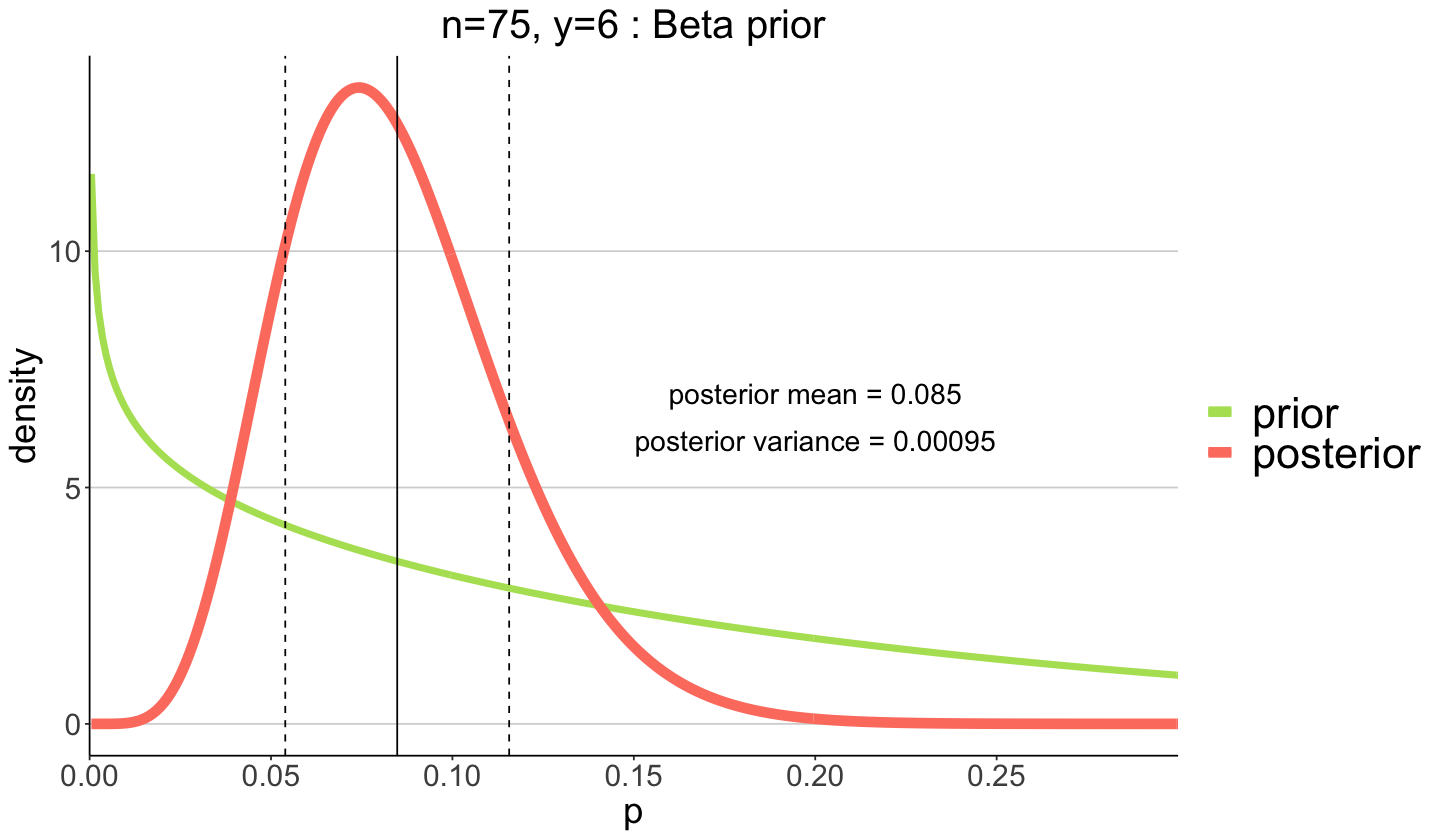

In [5]:
plt <- ggplot() +
geom_line(
    aes(x = p, y = beta_prior, color = "prior"), size = 2, linetype = "solid"
) +
geom_line(
    aes(x = p, y = posterior, color = "posterior"), size = 3, linetype = "solid"
)  +
geom_vline(xintercept = mean_post, linetype = "solid") +
geom_vline(xintercept = mean_post + sqrt(var_post), linetype = "dashed") +
geom_vline(xintercept = mean_post - sqrt(var_post), linetype = "dashed") +
annotate(
    "text", 
    0.2, 
    7, 
    label = glue("posterior mean = {round(mean_post, 3)}"), 
    # hjust = -0.1, 
    # vjust = 3,
    size = 6
) +
annotate(
    "text", 
    0.2, 
    6, 
    label = glue("posterior variance = {round(var_post, 5)}"), 
    # hjust = -0.1, 
    # vjust = 3,
    size = 6
) +
theme_classic() +
theme(
    plot.title   = element_text(size = fontsize + 2, hjust = 0.5),
    axis.title   = element_text(size = fontsize),
    axis.text    = element_text(size = fontsize - 4),
    legend.title = element_text(size = fontsize),
    legend.text  = element_text(size = fontsize + 4),
    # legend.position = c(0.8, 0.825),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title = glue("n={n}, y={k} : Beta prior"),
    x     = "p",
    y     = "density",
) +
coord_cartesian(xlim = c(0, 0.3)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_color_manual(
     name = "",
     values = c(colors[3], colors[1]),
     breaks = c("prior", "posterior")
)

plt

The frequentist estimator for the Binomial distribution is $\hat{p}=8.0\%$ while a Bayesian estimator, such as the mean of the posterior, is $8.5\%$. The two are sensibly different!

## D)

We define the null hypothesis as

$$
H_0\,\,:\,\, p \ge p_0 = 15\%
$$

that corresponds to having a new method that is no better than the traditional one.

The alternative hypothesis is defined as

$$
H_1\,\,:\,\, p < p_0
$$

To perform this HT in the Bayesian way, we need to compute

$$
P(H_0\,\,:\,\, p \ge p_0\,|\,y) = \int_{p_0}^{1} g(p\,|\,y) dp
$$

where $g$ is the posterior probability.

We reject the null hypothesis at a level of significance $\alpha$ if that integral is smaller than $\alpha$.

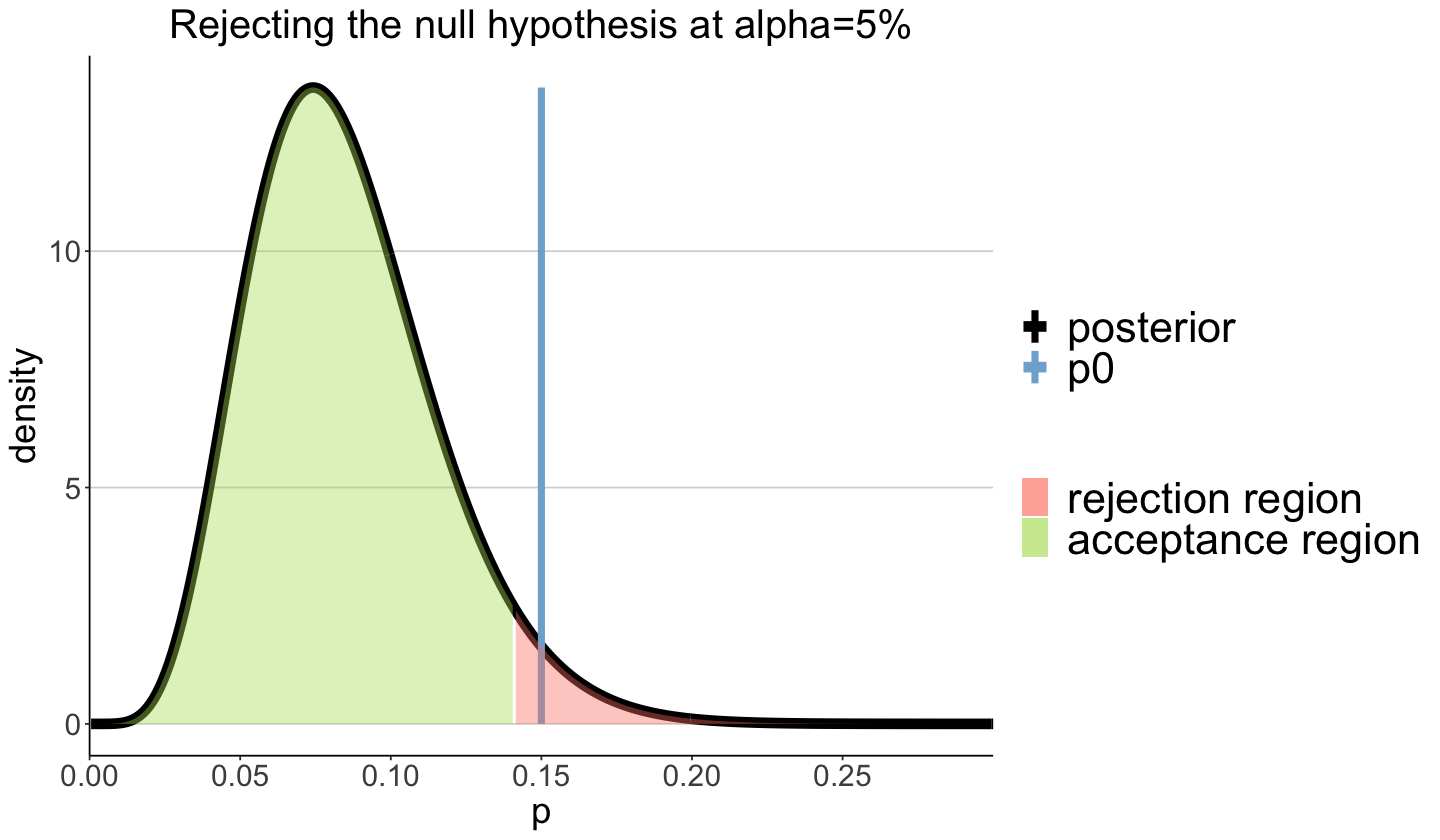

In [6]:
p0   <- 0.15
sl   <- 0.05
p_h0 <- 1 - pbeta(p0, a_post, b_post)
p_sl <- qbeta(1 - sl, a_post, b_post)

plt <- ggplot() +
geom_line(
    aes(
        x     = p,
        y     = posterior,
        color = "posterior"
    ),
    size      = 3,
    linetype  = "solid"
) +
geom_linerange(
    aes(
        x     = p0,
        ymin  = 0,
        ymax  = max(posterior),
        color = "p0"
    ),
    linetype  = "solid",
    size      = 2
) +
geom_area(
    aes(
        x     = p[p > p_sl],
        y     = posterior[p > p_sl],
        fill  = "rejection region"
    ),
    alpha     = 0.4
) +
geom_area(
    aes(
        x     = p[p <= p_sl],
        y     = posterior[p <= p_sl],
        fill  = "acceptance region"
    ),
    alpha     = 0.4
) +
theme_classic() +
theme(
    plot.title   = element_text(size = fontsize + 2, hjust = 0.5),
    axis.title   = element_text(size = fontsize),
    axis.text    = element_text(size = fontsize - 4),
    legend.title = element_text(size = fontsize),
    legend.text  = element_text(size = fontsize + 4),
    # legend.position = c(0.8, 0.825),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title = glue("Rejecting the null hypothesis at alpha=5%"),
    x     = "p",
    y     = "density",
) +
coord_cartesian(xlim = c(0, 0.3)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_color_manual(
     name = "",
     values = c("black", colors[2]),
     breaks = c("posterior", "p0")
) +
scale_fill_manual(
     name = "",
     values = c(colors[1], colors[3]),
     breaks = c("rejection region", "acceptance region")
)

plt

In [7]:
cat(
    glue(
        "P(p >= p_0 | y) = {round(p_h0,4)} is smaller than the level of significance alpha = {sl}"
    )
)

P(p >= p_0 | y) = 0.0313 is smaller than the level of significance alpha = 0.05

We reject the null hypothesis at a $\alpha=5\%$ level of significance, as $P(H_0)<\alpha$.

## E)

The null and alternative hypothesis are the same as above. 

Assuming a frequentist point of view, the null distribution of the test statistic is the ssampling distribution of the test statistic, given that the null hypothesis is true:

$$
P(y\,|\,H_0) = \text{Binom}(y\,|\,n,\,p=0.15)
$$

We set the level of significance at $\alpha=5\%$. However, dealing with a discrete distribution, we have to change our level of significance to the closest possible value, that is $\alpha=5.44\%$.

We then define the rejection region for the null hypothesis to be the region of the cumulative density function that stays below the level of significance.

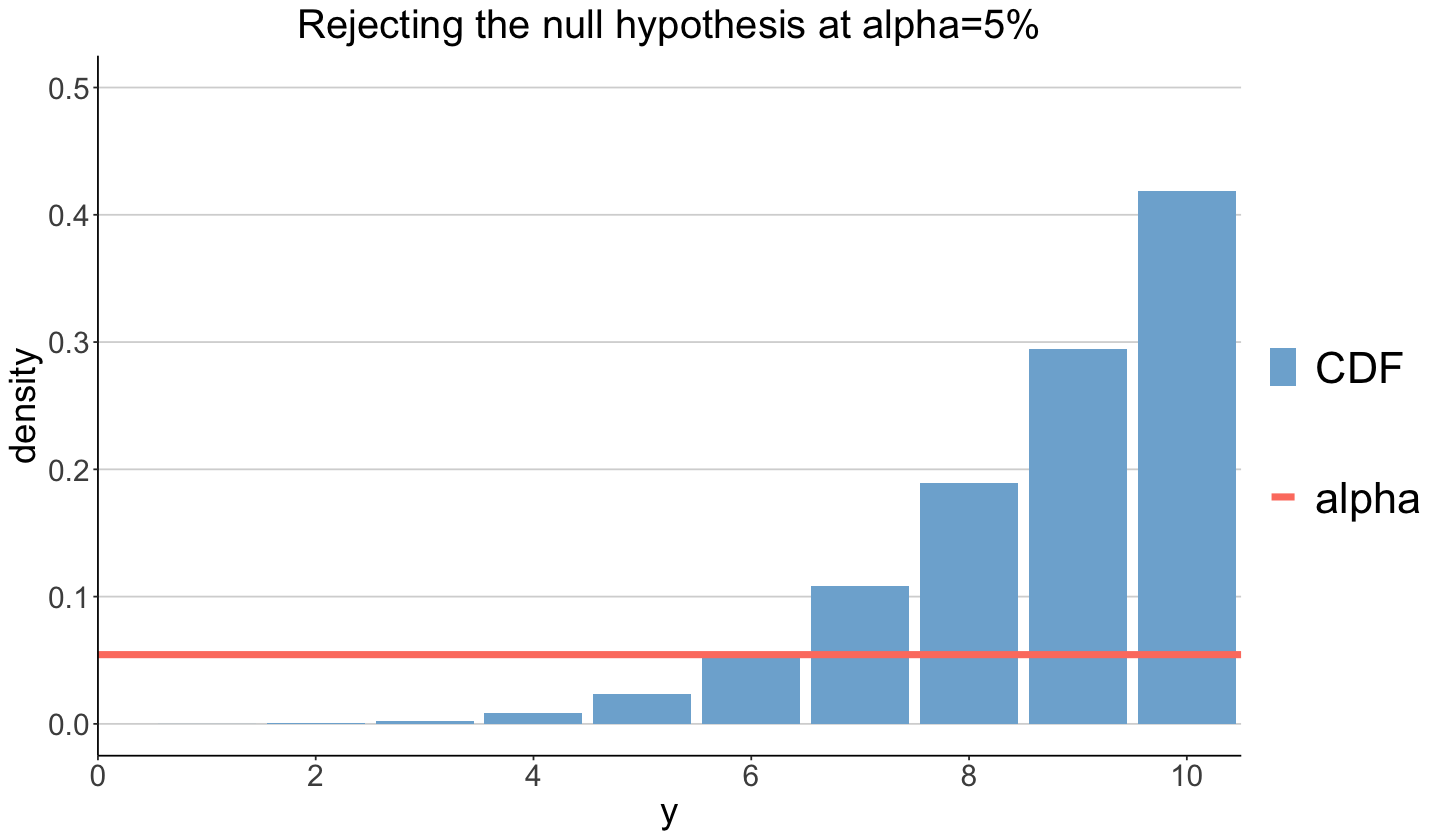

In [8]:
xgrid <- 0:30
cdf   <- pbinom(xgrid, size = n, prob = p0)

plt <- ggplot() +
geom_col(aes(x = xgrid, y = cdf, fill = "CDF")) +
geom_hline(aes(yintercept = 0.0544, color = "alpha"), size=2) +
theme_classic() +
theme(
    plot.title   = element_text(size = fontsize + 2, hjust = 0.5),
    axis.title   = element_text(size = fontsize),
    axis.text    = element_text(size = fontsize - 4),
    legend.title = element_text(size = fontsize),
    legend.text  = element_text(size = fontsize + 4),
    # legend.position = c(0.8, 0.825),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title = glue("Rejecting the null hypothesis at alpha=5%"),
    x     = "y",
    y     = "density",
) +
coord_cartesian(xlim = c(0, 10.5), ylim = c(0, 0.5)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_color_manual(
     name = "",
     values = c(colors[1]),
     breaks = c("alpha")
) +
scale_fill_manual(
     name = "",
     values = c(colors[2]),
     breaks = c("CDF")
)
plt

Our number of Bernoulli successes $k=6$ lies in the rejection region. To be precise, it lies exactly on the boundary between the acceptance and rejection region. Thus, we reject the null hypothesis.

In [9]:
pval <- pbinom(k, size = n, prob = p0)

cat(
    glue("
        The p-value is {round(pval, 4)}, which is exactly the level of significance alpha=0.0544.
    ")
)

    The p-value is 0.0544, which is exactly the level of significance alpha=0.0544.

Using the frequentist approach, we still reject the null hypothesis.

----

# Exercise 2 

Ladislaus Josephovich Bortkiewicz was a Russian economist and statistician. He noted that the Poisson distribution can be very useful in applied statistics when describing low-frequency events in a large population. In a famous example he showed that the number of deaths by horse kick among the Prussian army follows the Poisson distribution.

Considering the following two sets of observations taken over a fixed large time interval in two different corps:

| $y$ death soldiers  | 0   | 1  | 2  | 3  | 4 | $\ge$ 5 |
|------------------   |-----|----|----|----|---|------|
| $n_1$ obs           | 109 | 65 | 22 | 3  | 1 | 0    |
| $n_2$ obs           | 144 | 91 | 32 | 11 | 2 | 0    |

A) Assuming a uniform prior, compute and plot the posterior distribution for $\lambda$, the death rate over the measurement time. Determine the posterior mean, median and variance and compute the $95/%$ credibility interval.

B) Assuming a Jefrrey's prior, compute and plot the posterior distribution for $\lambda$, the death rate over the measurement time. Determine the posterior mean, median and variance and compute the $95/%$ credibility interval.

## A)

A Poisson likelihood with a uniform (improper) prior leads to a Gamma posterior $\Gamma(\alpha,\,\lambda)$ after $n$ observations $\{y_k\}$ with parameters

$$
\begin{cases}
    \alpha = \sum_k y_k + 1\\
    \lambda = n
\end{cases}
$$

In [10]:
y   <- c(  0,  1,  2,  3, 4)
n_1 <- c(109, 65, 22,  3, 1)
n_2 <- c(144, 91, 32, 11, 2)

a_1 <- 1 + sum(y * n_1)
l_1 <- sum(n_1)

a_2 <- 1 + sum(y * n_2)
l_2 <- sum(n_2)

In [11]:
xmin     <- 0
xmax     <- 1.4
n_points <- 500
xgrid    <- seq(xmin, xmax, len = n_points)

post_1 <- dgamma(xgrid, shape = a_1, rate = l_1)
post_2 <- dgamma(xgrid, shape = a_2, rate = l_2)

flat_prior_df <- tibble(x = xgrid, post_1 = post_1, post_2 = post_2)

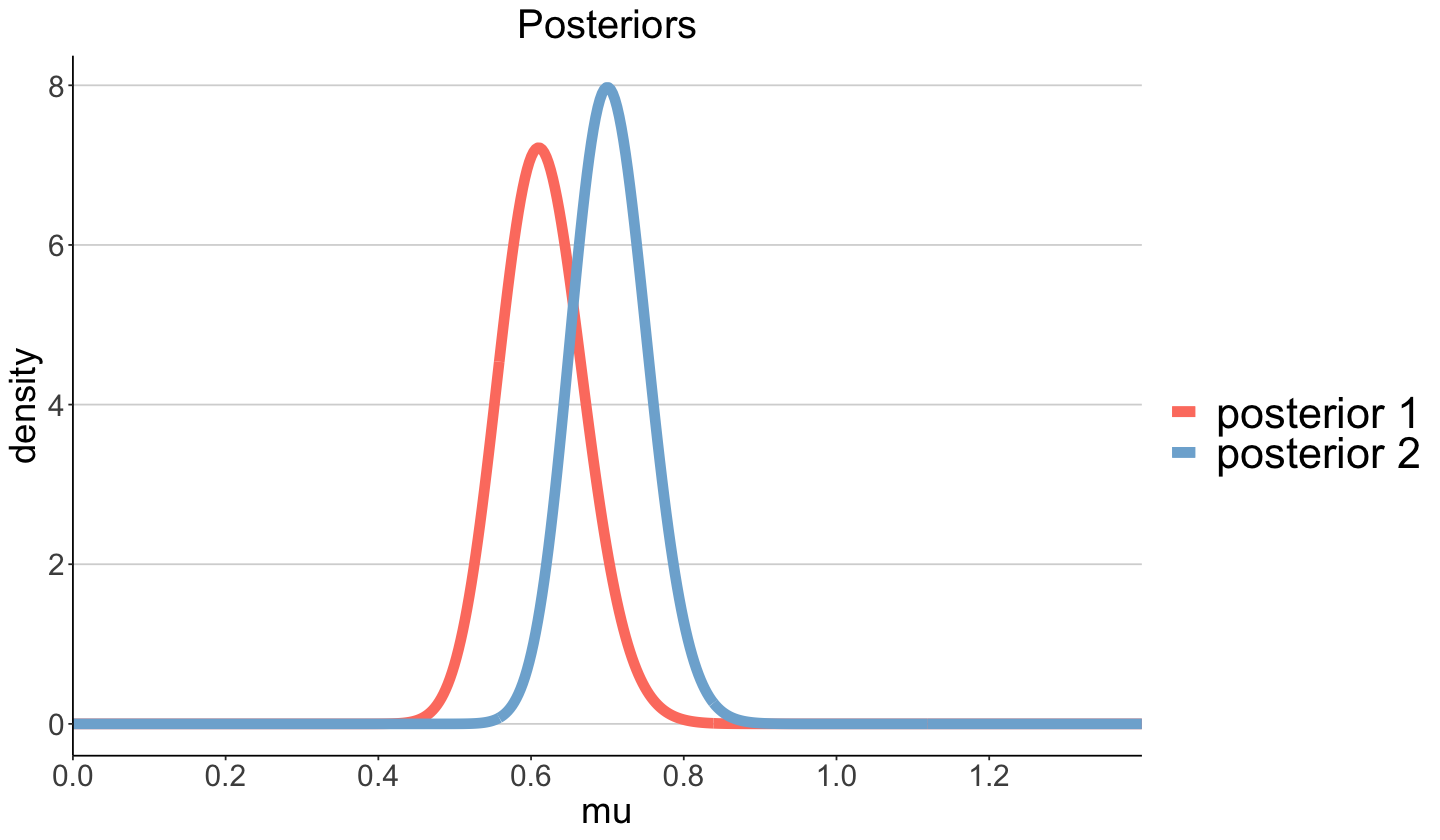

In [12]:
plt <- ggplot(data = flat_prior_df) +
geom_line(
    aes(
        x     = x,
        y     = post_1,
        color = "posterior 1"
    ),
    size      = 3,
    linetype  = "solid"
) +
geom_line(
    aes(
        x     = x,
        y     = post_2,
        color = "posterior 2"
    ),
    size      = 3,
    linetype  = "solid"
) +
theme_classic() +
theme(
    plot.title   = element_text(size = fontsize + 2, hjust = 0.5),
    axis.title   = element_text(size = fontsize),
    axis.text    = element_text(size = fontsize - 4),
    legend.title = element_text(size = fontsize),
    legend.text  = element_text(size = fontsize + 4),
    # legend.position = c(0.8, 0.825),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title = glue("Posteriors"),
    x     = "mu",
    y     = "density",
) +
# coord_cartesian(xlim = c(0, 0.3)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_color_manual(
     name = "",
     values = c(colors[1], colors[2]),
     breaks = c("posterior 1", "posterior 2")
)

plt

In [13]:
# mean
mean_1 <- a_1 / l_1
mean_2 <- a_2 / l_2

# mode
mode_1 <- (a_1 - 1) / l_1
mode_2 <- (a_2 - 1) / l_2

# variance
var_1  <- a_1 / l_1^2
var_2  <- a_2 / l_2^2

# median
median_1 <- qgamma(0.5, shape = a_1, rate = l_1)
median_2 <- qgamma(0.5, shape = a_2, rate = l_2)

# credibility intervals
alpha <- 0.05
q_l   <- alpha / 2
q_r   <- 1 - q_l

min_ci_1 <- qgamma(q_l, shape = a_1, rate = l_1)
max_ci_1 <- qgamma(q_r, shape = a_1, rate = l_1)

min_ci_2 <- qgamma(q_l, shape = a_2, rate = l_2)
max_ci_2 <- qgamma(q_r, shape = a_2, rate = l_2)

cat(
    "SET N° 1\n",
    glue("Mean     = {round(mean_1,3)}"), "\n",
    glue("Mode     = {round(mode_1,3)}"), "\n",
    glue("Variance = {round(var_1,3)}"), "\n",
    glue("Median   = {round(median_1,3)}"), "\n",
    glue("95% CI   = [{round(min_ci_1,3)}, {round(max_ci_1,3)}]"), "\n"
)
cat("\n")
cat(
    "SET N° 2\n",
    glue("Mean     = {round(mean_2,3)}"), "\n",
    glue("Mode     = {round(mode_2,3)}"), "\n",
    glue("Variance = {round(var_2,3)}"), "\n",
    glue("Median   = {round(median_2,3)}"), "\n",
    glue("95% CI   = [{round(min_ci_2,3)}, {round(max_ci_2,3)}]"), "\n"
)

SET N° 1
 Mean     = 0.615 
 Mode     = 0.61 
 Variance = 0.003 
 Median   = 0.613 
 95% CI   = [0.511, 0.728] 

SET N° 2
 Mean     = 0.704 
 Mode     = 0.7 
 Variance = 0.003 
 Median   = 0.702 
 95% CI   = [0.609, 0.805] 


## B)

A Poisson likelihood with a Jeffrey's (improper) prior leads to a Gamma posterior $\Gamma(\alpha,\,\lambda)$ after $n$ observations $\{y_k\}$ with parameters

$$
\begin{cases}
    \alpha = \sum_k y_k + \frac{1}{2}\\
    \lambda = n
\end{cases}
$$

In [14]:
y   <- c(  0,  1,  2,  3, 4)
n_1 <- c(109, 65, 22,  3, 1)
n_2 <- c(144, 91, 32, 11, 2)

a_1 <- 0.5 + sum(y * n_1)
l_1 <- sum(n_1)

a_2 <- 0.5 + sum(y * n_2)
l_2 <- sum(n_2)

In [15]:
xmin     <- 0
xmax     <- 1.4
n_points <- 500
xgrid    <- seq(xmin, xmax, len = n_points)

post_1 <- dgamma(xgrid, shape = a_1, rate = l_1)
post_2 <- dgamma(xgrid, shape = a_2, rate = l_2)

flat_prior_df <- tibble(x = xgrid, post_1 = post_1, post_2 = post_2)

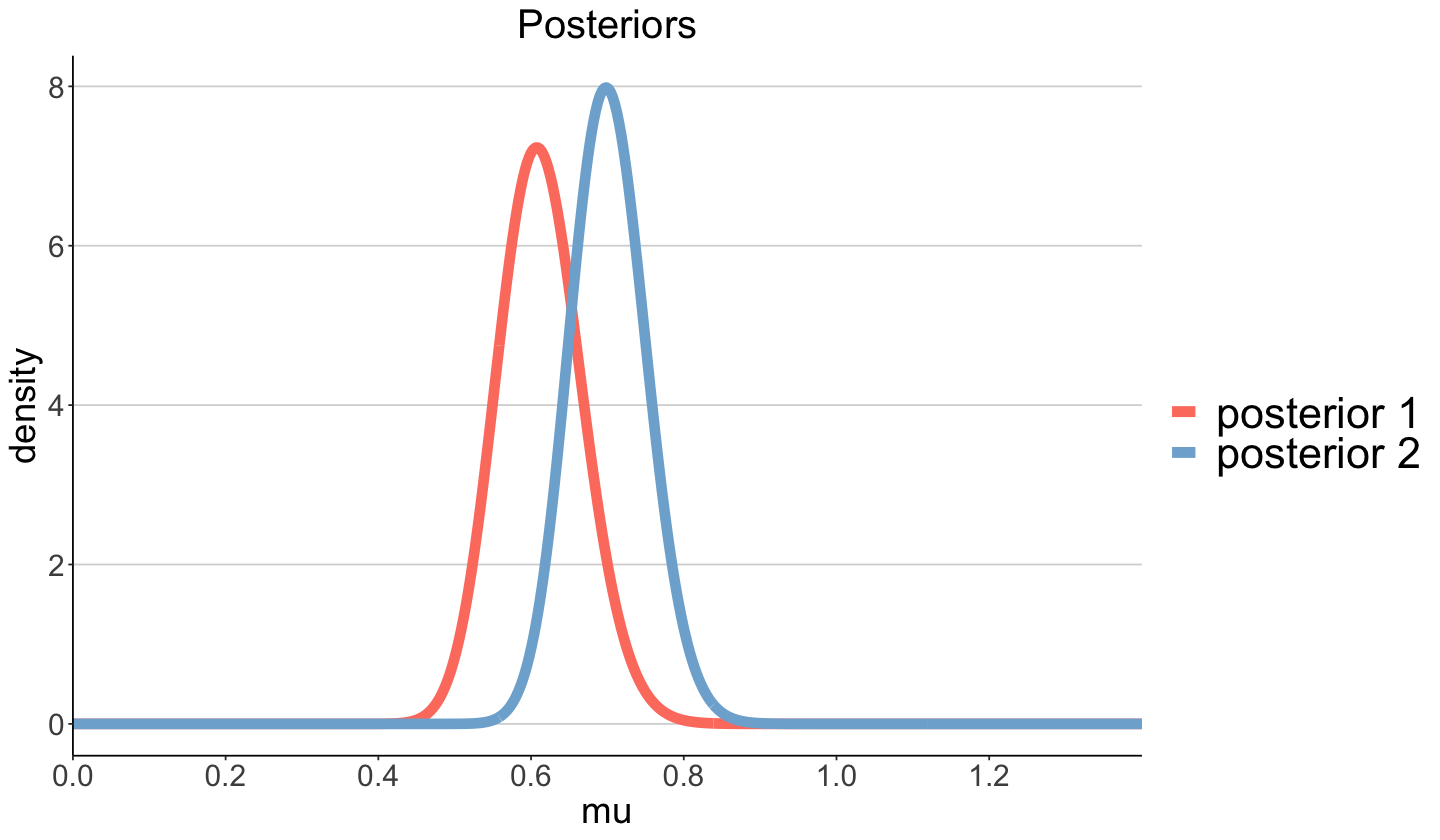

In [16]:
plt <- ggplot(data = flat_prior_df) +
geom_line(
    aes(
        x     = x,
        y     = post_1,
        color = "posterior 1"
    ),
    size      = 3,
    linetype  = "solid"
) +
geom_line(
    aes(
        x     = x,
        y     = post_2,
        color = "posterior 2"
    ),
    size      = 3,
    linetype  = "solid"
) +
theme_classic() +
theme(
    plot.title   = element_text(size = fontsize + 2, hjust = 0.5),
    axis.title   = element_text(size = fontsize),
    axis.text    = element_text(size = fontsize - 4),
    legend.title = element_text(size = fontsize),
    legend.text  = element_text(size = fontsize + 4),
    # legend.position = c(0.8, 0.825),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title = glue("Posteriors"),
    x     = "mu",
    y     = "density",
) +
# coord_cartesian(xlim = c(0, 0.3)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_color_manual(
     name = "",
     values = c(colors[1], colors[2]),
     breaks = c("posterior 1", "posterior 2")
)

plt

In [17]:
# mean
mean_1 <- a_1 / l_1
mean_2 <- a_2 / l_2

# mode
mode_1 <- (a_1 - 1) / l_1
mode_2 <- (a_2 - 1) / l_2

# variance
var_1  <- a_1 / l_1^2
var_2  <- a_2 / l_2^2

# median
median_1 <- qgamma(0.5, shape = a_1, rate = l_1)
median_2 <- qgamma(0.5, shape = a_2, rate = l_2)

# credibility intervals
alpha <- 0.05
q_l   <- alpha / 2
q_r   <- 1 - q_l

min_ci_1 <- qgamma(q_l, shape = a_1, rate = l_1)
max_ci_1 <- qgamma(q_r, shape = a_1, rate = l_1)

min_ci_2 <- qgamma(q_l, shape = a_2, rate = l_2)
max_ci_2 <- qgamma(q_r, shape = a_2, rate = l_2)

cat(
    "SET N° 1\n",
    glue("Mean     = {round(mean_1,3)}"), "\n",
    glue("Mode     = {round(mode_1,3)}"), "\n",
    glue("Variance = {round(var_1,3)}"), "\n",
    glue("Median   = {round(median_1,3)}"), "\n",
    glue("95% CI   = [{round(min_ci_1,3)}, {round(max_ci_1,3)}]"), "\n"
)
cat("\n")
cat(
    "SET N° 2\n",
    glue("Mean     = {round(mean_2,3)}"), "\n",
    glue("Mode     = {round(mode_2,3)}"), "\n",
    glue("Variance = {round(var_2,3)}"), "\n",
    glue("Median   = {round(median_2,3)}"), "\n",
    glue("95% CI   = [{round(min_ci_2,3)}, {round(max_ci_2,3)}]"), "\n"
)

SET N° 1
 Mean     = 0.613 
 Mode     = 0.608 
 Variance = 0.003 
 Median   = 0.611 
 95% CI   = [0.509, 0.726] 

SET N° 2
 Mean     = 0.702 
 Mode     = 0.698 
 Variance = 0.003 
 Median   = 0.701 
 95% CI   = [0.607, 0.803] 


----

# Exercise 3

A study on water quality of streams, a high level of bacter X was defined as a level greater than $100$ per $100$ ml of stream water. A number $n= 116$ samples were taken from streams having a high environmental impact on pandas. Out of these, $y= 11$ had a high bacter X level.

iIndicating with $p$ the probability that a sample of water taken from the stream has a high bacter X level:

A) Find the frequentist estimator for $p$.

B) Using a `Beta(1, 10)` prior for $p$, compute the posterior distribution.

C) Find the bayesian estimator for $p$, the posterior mean and variance, and a $95\%$ credibility 
interval.

D) Test the hypothesis

$$
    H_0\,\, : \,\,p=0.1 \,\,\,\,\,\, vs \,\,\,\,\,\, H_1\,\, : \,\,p\ne 0.1
$$

at a $5\%$ level of significance with both the frequentist and bayesian approach.

A new measurement, performed one month later on $n= 165$ water samples, gives $y= 9$ high bacter X level:

E) Find the frequentist estimator for $p$.

F) Using both a `Beta(1, 10)` prior for $p$ and the posterior of the older measurements as prior, compute the posterior distribution.

G) Find the bayesian estimator for $p$, the posterior mean and variance, and a $95\%$ credibility interval.

H) Test the hypothesis

$$
    H_0\,\, : \,\,p=0.1 \,\,\,\,\,\, vs \,\,\,\,\,\, H_1\,\, : \,\,p\ne 0.1
$$

at a $5\%$ level of significance with both the frequentist and bayesian approach.

## A)

The process is a Bernoulli process where the success is the presence of high bacter level. The unbiased estimator for $p$ in the frequentist approach is

$$
P_{\text{f}} = \frac{y}{n} = \frac{11}{116} \simeq 9.5\%
$$

## B)

The `Beta(1, 10)` prior is a conjugate prior for the binomial distribution and thus the posterior is again another Beta distribution with parameters

$$
\begin{cases}
    \alpha_{\text{post}} = \alpha + y = 12\\
    \beta_{\text{post}}  = \beta + n - y = 115
\end{cases}
$$

In [18]:
# total number of tests
n <- 116
# number of successes
k <- 11

# priot beta parameters
a_prior <- 1
b_prior <- 10

# posterior beta parameters
a_post <- a_prior + k
b_post <- b_prior + n - k

n_grid  <- 1000
# the parameter we want to infer
p       <- seq(from = 1 / (2 * n_grid), by = 1 / n_grid, length.out = n_grid)
delta_p <- 1 / n_grid

# prior distribution
beta_prior <- dbeta(x = p, shape1 = a_prior, shape2 = b_prior)
# posterior distribution
posterior  <- dbeta(x = p, shape1 = a_post,  shape2 = b_post)

# compute mean and variance of the posterior
mean_post <- a_post / (a_post + b_post)
var_post  <- (a_post * b_post) / ((a_post + b_post)^2 * (a_post + b_post + 1))

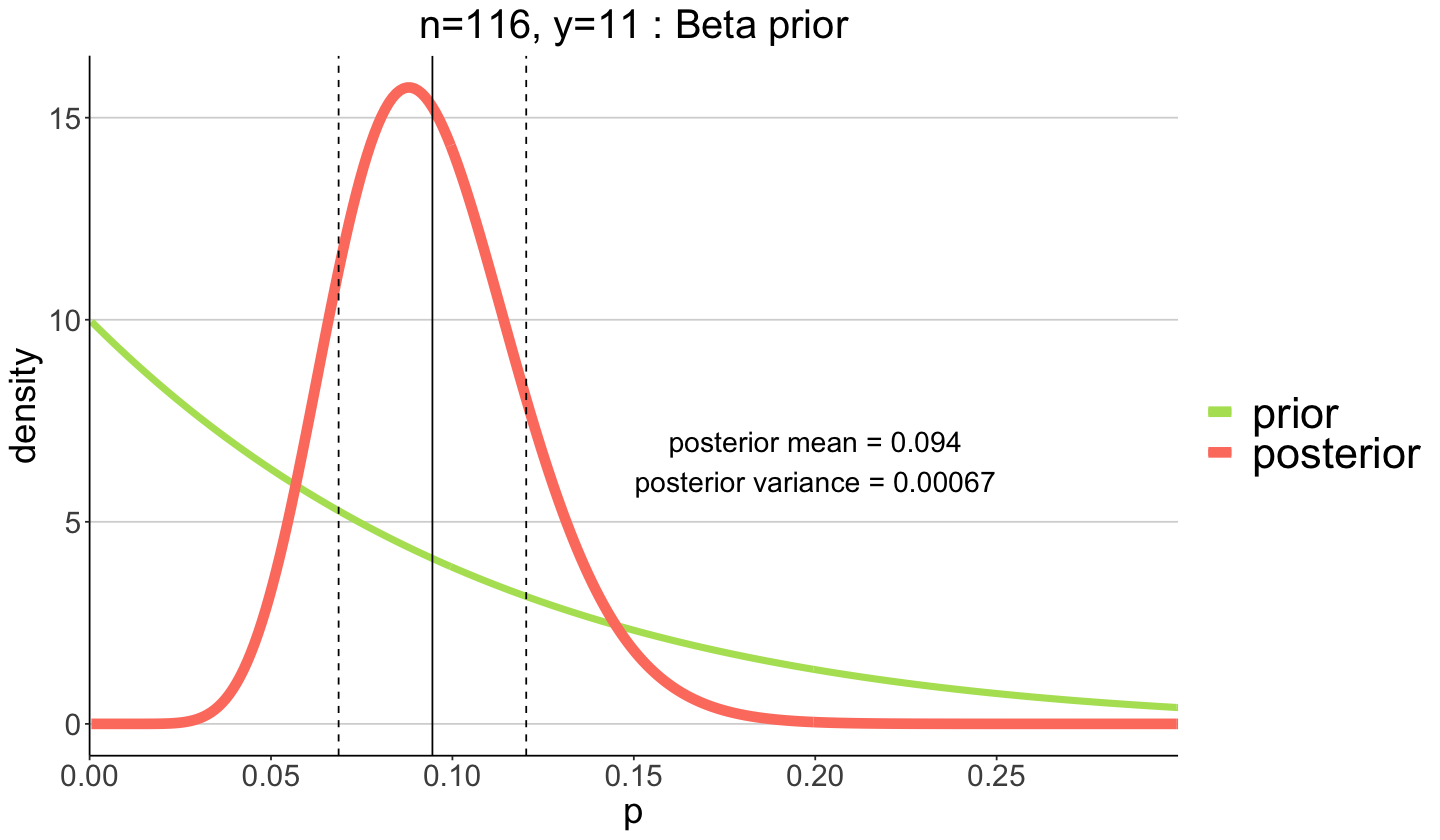

In [19]:
plt <- ggplot() +
geom_line(
    aes(x = p, y = beta_prior, color = "prior"), size = 2, linetype = "solid"
) +
geom_line(
    aes(x = p, y = posterior, color = "posterior"), size = 3, linetype = "solid"
)  +
geom_vline(xintercept = mean_post, linetype = "solid") +
geom_vline(xintercept = mean_post + sqrt(var_post), linetype = "dashed") +
geom_vline(xintercept = mean_post - sqrt(var_post), linetype = "dashed") +
annotate(
    "text", 
    0.2, 
    7, 
    label = glue("posterior mean = {round(mean_post, 3)}"), 
    # hjust = -0.1, 
    # vjust = 3,
    size = 6
) +
annotate(
    "text", 
    0.2, 
    6, 
    label = glue("posterior variance = {round(var_post, 5)}"), 
    # hjust = -0.1, 
    # vjust = 3,
    size = 6
) +
theme_classic() +
theme(
    plot.title   = element_text(size = fontsize + 2, hjust = 0.5),
    axis.title   = element_text(size = fontsize),
    axis.text    = element_text(size = fontsize - 4),
    legend.title = element_text(size = fontsize),
    legend.text  = element_text(size = fontsize + 4),
    # legend.position = c(0.8, 0.825),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title = glue("n={n}, y={k} : Beta prior"),
    x     = "p",
    y     = "density",
) +
coord_cartesian(xlim = c(0, 0.3)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_color_manual(
     name = "",
     values = c(colors[3], colors[1]),
     breaks = c("prior", "posterior")
)

plt

# C)

In [20]:
# mean
mean_1 <- a_post / (a_post + b_post)

# mode
mode_1 <- (a_post - 1) / (a_post + b_post - 2)

# variance
var_1  <- (a_post * b_post) / ((a_post + b_post)^2 * (a_post + b_post + 1))

# median
median_1 <- qbeta(0.5, shape1 = a_post, shape2 = b_post)

# credibility intervals
alpha <- 0.05
q_l   <- alpha / 2
q_r   <- 1 - q_l

min_ci_1 <- qbeta(q_l, shape1 = a_post, shape2 = b_post)
max_ci_1 <- qbeta(q_r, shape1 = a_post, shape2 = b_post)

cat(
    "Bayesian approach\n",
    glue("Mean     = {round(mean_1,4)}"), "\n",
    glue("Mode     = {round(mode_1,4)}"), "\n",
    glue("Variance = {round(var_1,4)}"), "\n",
    glue("Median   = {round(median_1,4)}"), "\n",
    glue("95% CI   = [{round(min_ci_1,4)}, {round(max_ci_1,4)}]"), "\n"
)

Bayesian approach
 Mean     = 0.0945 
 Mode     = 0.088 
 Variance = 7e-04 
 Median   = 0.0924 
 95% CI   = [0.0502, 0.1508] 


## D)

This is a two-tailed hypothesis test. 

In this case, the probability related to the null hypothesis is zero (punctual probability), thus to test $H_0$ at a significance level $\alpha$ we need to compute a $(1-\alpha) \times 100$ credibility interval for $p$. Then, we check where $p_0=0.1$ falls: if it lies inside the credibility interval then the null hypothesis cannot be rejected at such level of significance.

We have already computed the $95\%$ credibility interval, that is

$$
p \in [0.0502,\,0.1508]
$$

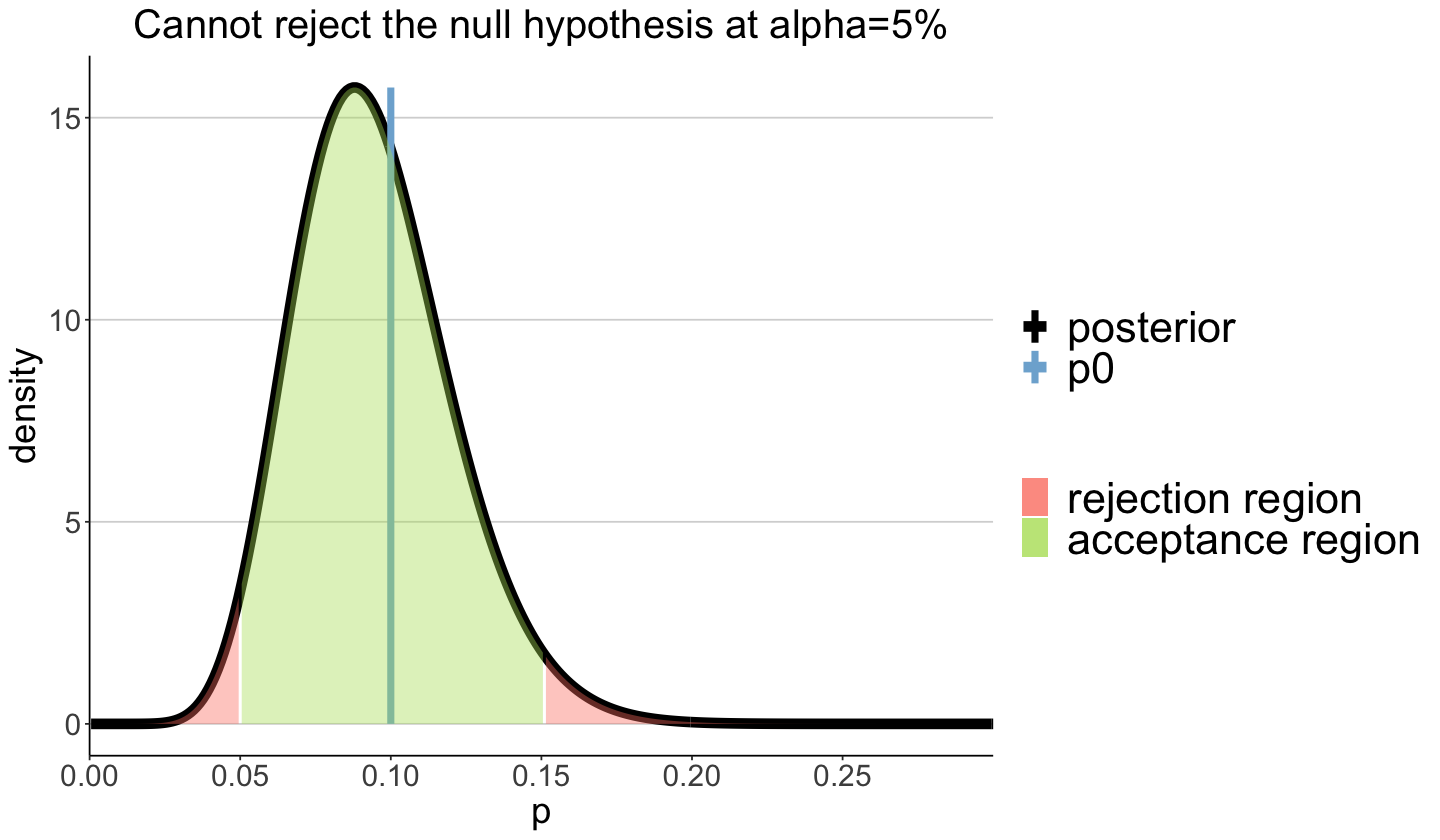

In [21]:
p0   <- 0.10

plt <- ggplot() +
geom_line(
    aes(
        x     = p,
        y     = posterior,
        color = "posterior"
    ),
    size      = 3,
    linetype  = "solid"
) +
geom_linerange(
    aes(
        x     = p0,
        ymin  = 0,
        ymax  = max(posterior),
        color = "p0"
    ),
    linetype  = "solid",
    size      = 2
) +
geom_area(
    aes(
        x     = p[(p < min_ci_1)],
        y     = posterior[(p < min_ci_1)],
        fill  = "rejection region"
    ),
    alpha     = 0.4
) +
geom_area(
    aes(
        x     = p[(p > max_ci_1)],
        y     = posterior[(p > max_ci_1)],
        fill  = "rejection region"
    ),
    alpha     = 0.4
) +
geom_area(
    aes(
        x     = p[(p > min_ci_1) & (p < max_ci_1)],
        y     = posterior[(p > min_ci_1) & (p < max_ci_1)],
        fill  = "acceptance region"
    ),
    alpha     = 0.4
) +
theme_classic() +
theme(
    plot.title   = element_text(size = fontsize + 2, hjust = 0.5),
    axis.title   = element_text(size = fontsize),
    axis.text    = element_text(size = fontsize - 4),
    legend.title = element_text(size = fontsize),
    legend.text  = element_text(size = fontsize + 4),
    # legend.position = c(0.8, 0.825),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title = glue("Cannot reject the null hypothesis at alpha=5%"),
    x     = "p",
    y     = "density",
) +
coord_cartesian(xlim = c(0, 0.3)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_color_manual(
     name = "",
     values = c("black", colors[2]),
     breaks = c("posterior", "p0")
) +
scale_fill_manual(
     name = "",
     values = c(colors[1], colors[3]),
     breaks = c("rejection region", "acceptance region")
)

plt

Since $p_0$ falls inside the $95\%$ credibility interval we cannot reject the null hypothesis at a level of significance $\alpha = 5\%$.

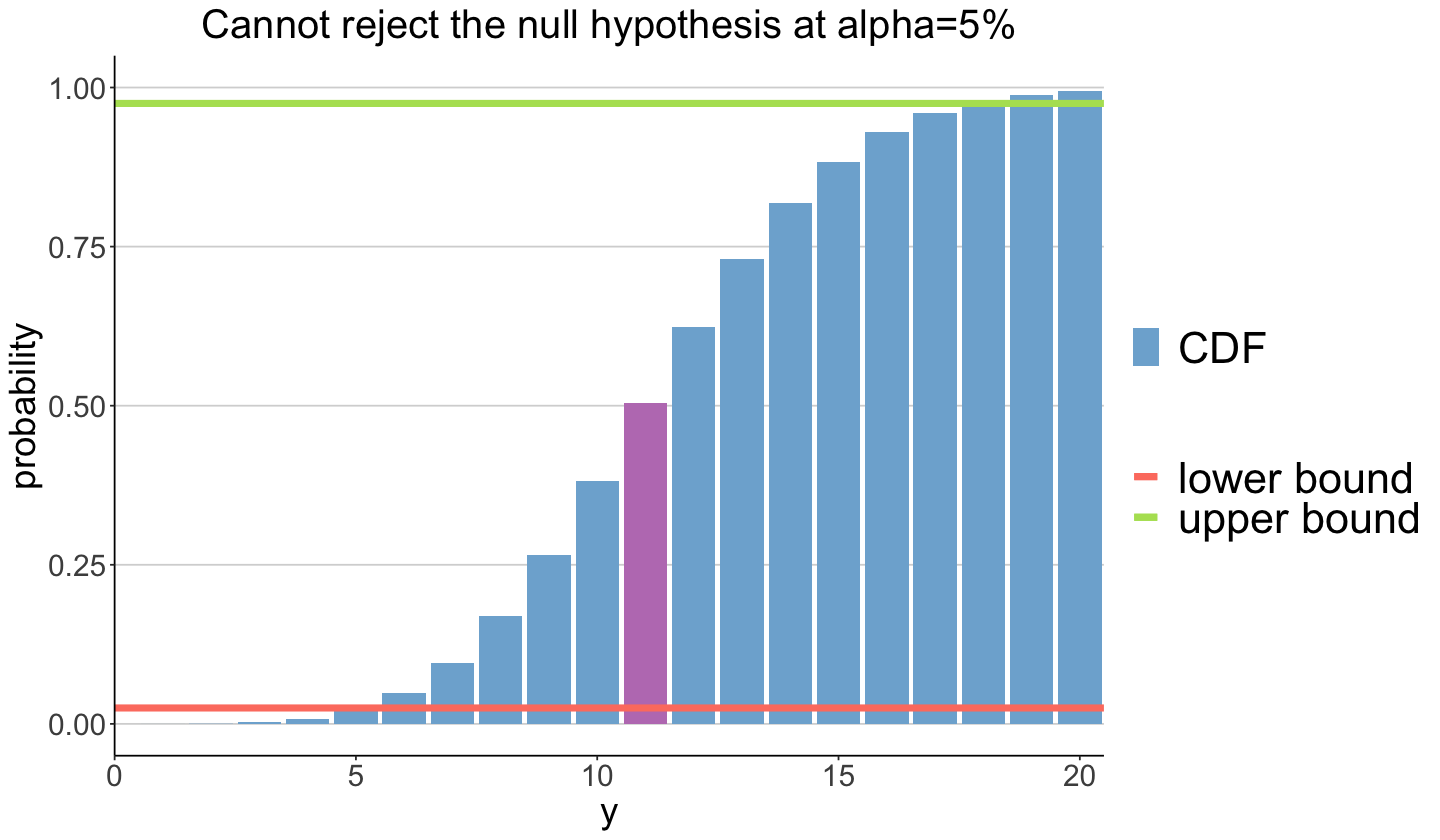

In [25]:
xgrid <- 0:30
cdf   <- pbinom(xgrid, size = n, prob = p0)

plt <- ggplot() +
geom_col(aes(x = xgrid, y = cdf, fill = "CDF")) +
geom_col(aes(x = 11,    y = pbinom(11, size = n, prob = p0)), fill = colors[4]) +
geom_hline(aes(yintercept = 0.025, color = "lower bound"), size = 2) +
geom_hline(aes(yintercept = 0.975, color = "upper bound"), size = 2) +
theme_classic() +
theme(
    plot.title   = element_text(size = fontsize + 2, hjust = 0.5),
    axis.title   = element_text(size = fontsize),
    axis.text    = element_text(size = fontsize - 4),
    legend.title = element_text(size = fontsize),
    legend.text  = element_text(size = fontsize + 4),
    # legend.position = c(0.8, 0.825),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title = glue("Cannot reject the null hypothesis at alpha=5%"),
    x     = "y",
    y     = "probability",
) +
coord_cartesian(xlim = c(0, 20.5), ylim = c(0, 1)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_color_manual(
     name = "",
     values = c(colors[1], colors[3]),
     breaks = c("lower bound", "upper bound")
) +
scale_fill_manual(
     name = "",
     values = c(colors[2]),
     breaks = c("CDF")
)
plt

The height of the $y=11$ is inside the accpetance region and thus we cannot reject the null hypothesis at a significance level of $\alpha=5\%$.

## E)

The process is a Bernoulli process where the success is the presence of high bacter level. The unbiased estimator for $p$ in the frequentist approach is

$$
P_{\text{f}} = \frac{y}{n} = \frac{9}{165} \simeq 5.46\%
$$

## F)

The `Beta(1, 10)` prior is a conjugate prior for the binomial distribution and thus the posterior is again another Beta distribution with parameters

$$
\begin{cases}
    \alpha_{\text{post}} = \alpha + y = 10\\
    \beta_{\text{post}}  = \beta + n - y = 166
\end{cases}
$$

Using as prior the posterior probability of the older measurements, we have that our prior is a `Beta(12, 115)` prior and the new posterior is a Beta distribution with parameters

$$
\begin{cases}
    \alpha_{\text{post}} = \alpha + y = 21\\
    \beta_{\text{post}}  = \beta + n - y = 271
\end{cases}
$$

In [26]:
# total number of tests
n <- 165
# number of successes
k <- 9

# priot beta parameters
a_prior <- 1
b_prior <- 10

a_old_post <- 12
b_old_post <- 115

# posterior beta parameters
a_post_1 <- a_prior    + k
b_post_1 <- b_prior    + n - k
a_post_2 <- a_old_post + k
b_post_2 <- b_old_post + n - k

n_grid  <- 1000
# the parameter we want to infer
p       <- seq(from = 1 / (2 * n_grid), by = 1 / n_grid, length.out = n_grid)
delta_p <- 1 / n_grid

# posterior distribution
posterior_1  <- dbeta(x = p, shape1 = a_post_1,  shape2 = b_post_1)
posterior_2  <- dbeta(x = p, shape1 = a_post_2,  shape2 = b_post_2)

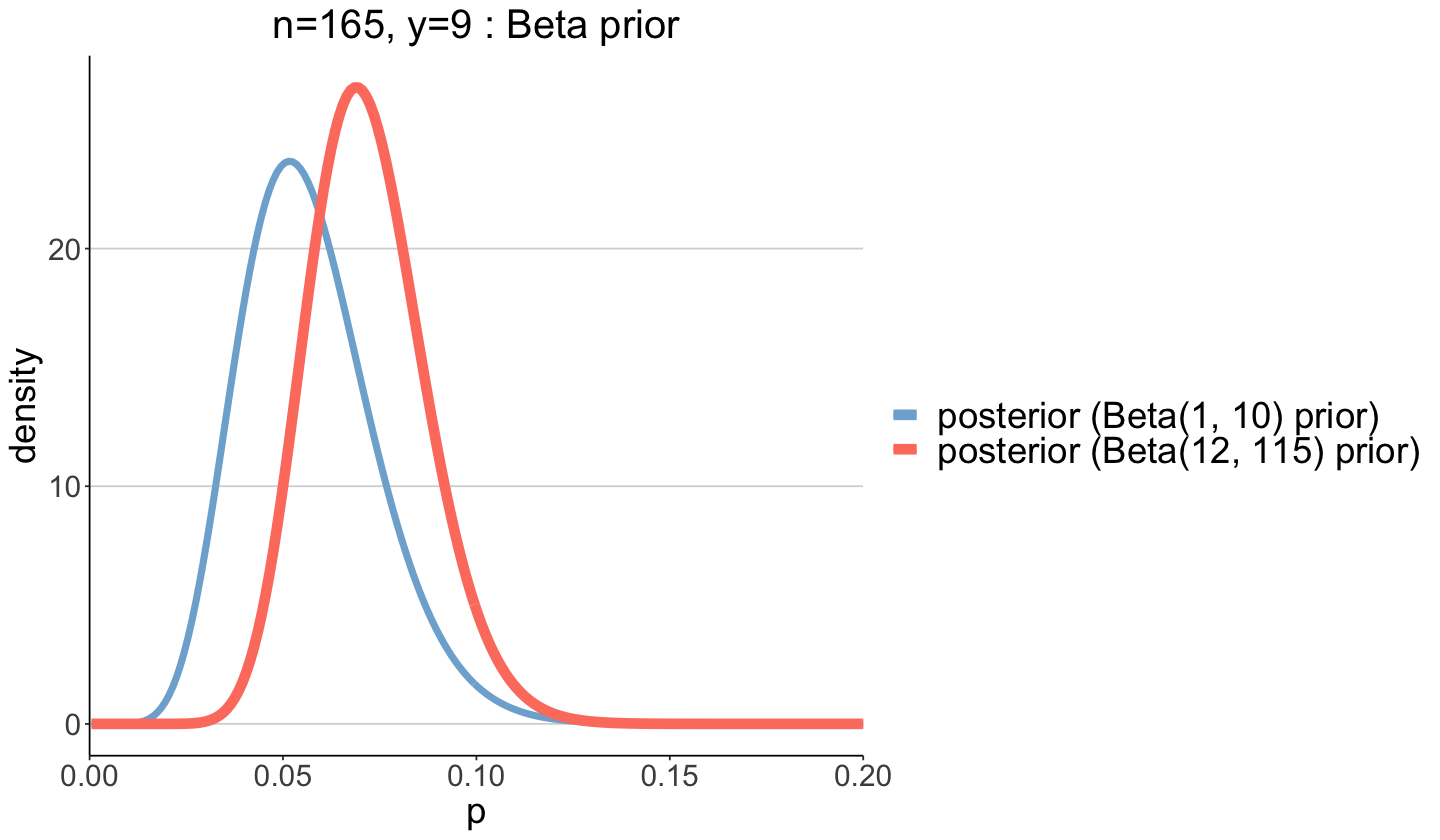

In [27]:
plt <- ggplot() +
geom_line(
    aes(x = p, y = posterior_1, color = "posterior (Beta(1, 10) prior)"), size = 2, linetype = "solid"
) +
geom_line(
    aes(x = p, y = posterior_2, color = "posterior (Beta(12, 115) prior)"), size = 3, linetype = "solid"
)  +
theme_classic() +
theme(
    plot.title   = element_text(size = fontsize + 2, hjust = 0.5),
    axis.title   = element_text(size = fontsize),
    axis.text    = element_text(size = fontsize - 4),
    legend.title = element_text(size = fontsize),
    legend.text  = element_text(size = fontsize ),
    # legend.position = c(0.8, 0.825),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title = glue("n={n}, y={k} : Beta prior"),
    x     = "p",
    y     = "density",
) +
coord_cartesian(xlim = c(0, 0.2)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_color_manual(
     name = "",
     values = c(colors[2], colors[1]),
     breaks = c("posterior (Beta(1, 10) prior)", "posterior (Beta(12, 115) prior)")
)

plt

## G)

In [28]:
# mean
mean_1 <- a_post_1 / (a_post_1 + b_post_1)
mean_2 <- a_post_2 / (a_post_2 + b_post_2)

# mode
mode_1 <- (a_post_1 - 1) / (a_post_1 + b_post_1 - 2)
mode_2 <- (a_post_2 - 1) / (a_post_2 + b_post_2 - 2)

# variance
var_1  <- (a_post_1 * b_post_1) / ((a_post_1 + b_post_1)^2 * (a_post_1 + b_post_1 + 1))
var_2  <- (a_post_2 * b_post_2) / ((a_post_2 + b_post_2)^2 * (a_post_2 + b_post_2 + 1))

# median
median_1 <- qbeta(0.5, shape1 = a_post_1, shape2 = b_post_1)
median_2 <- qbeta(0.5, shape1 = a_post_2, shape2 = b_post_2)

# credibility intervals
alpha <- 0.05
q_l   <- alpha / 2
q_r   <- 1 - q_l

min_ci_1 <- qbeta(q_l, shape1 = a_post_1, shape2 = b_post_1)
max_ci_1 <- qbeta(q_r, shape1 = a_post_1, shape2 = b_post_1)

min_ci_2 <- qbeta(q_l, shape1 = a_post_2, shape2 = b_post_2)
max_ci_2 <- qbeta(q_r, shape1 = a_post_2, shape2 = b_post_2)

cat(
    "PRIOR Beta(1, 10)\n",
    glue("Mean     = {round(mean_1,4)}"), "\n",
    glue("Mode     = {round(mode_1,4)}"), "\n",
    glue("Variance = {round(var_1,4)}"), "\n",
    glue("Median   = {round(median_1,4)}"), "\n",
    glue("95% CI   = [{round(min_ci_1,4)}, {round(max_ci_1,4)}]"), "\n"
)
cat("\n")
cat(
    "PRIOR Beta(12, 115)\n",
    glue("Mean     = {round(mean_2,4)}"), "\n",
    glue("Mode     = {round(mode_2,4)}"), "\n",
    glue("Variance = {round(var_2,4)}"), "\n",
    glue("Median   = {round(median_2,4)}"), "\n",
    glue("95% CI   = [{round(min_ci_2,4)}, {round(max_ci_2,4)}]"), "\n"
)

PRIOR Beta(1, 10)
 Mean     = 0.0568 
 Mode     = 0.0517 
 Variance = 3e-04 
 Median   = 0.0551 
 95% CI   = [0.0277, 0.0954] 

PRIOR Beta(12, 115)
 Mean     = 0.0719 
 Mode     = 0.069 
 Variance = 2e-04 
 Median   = 0.0709 
 95% CI   = [0.0452, 0.1042] 


## H)

Adopting the Bayesian approach, we simply need to check whether $p_0=0.10$ falls inside the $95\%$ credibility intervals we have just computed. If $p_0$ falls inside such intervals then we cannot reject the null hypothesis at a level of significance $\alpha=5\%$.

The two credibility intervals are 

1. For a fresh `Beta(1, 10)` prior
$$
    p \in [2.77\%,\,9.54\%]
$$

2. Using the old posterior `Beta(12, 115)` as prior
$$
    p \in [4.52\%,\,10.42\%]
$$

It is straightforward to say that in the former case we reject the null hypothesis while in the latter case we cannot reject the null hypothesis at a level of significance of $\alpha=5\%$.

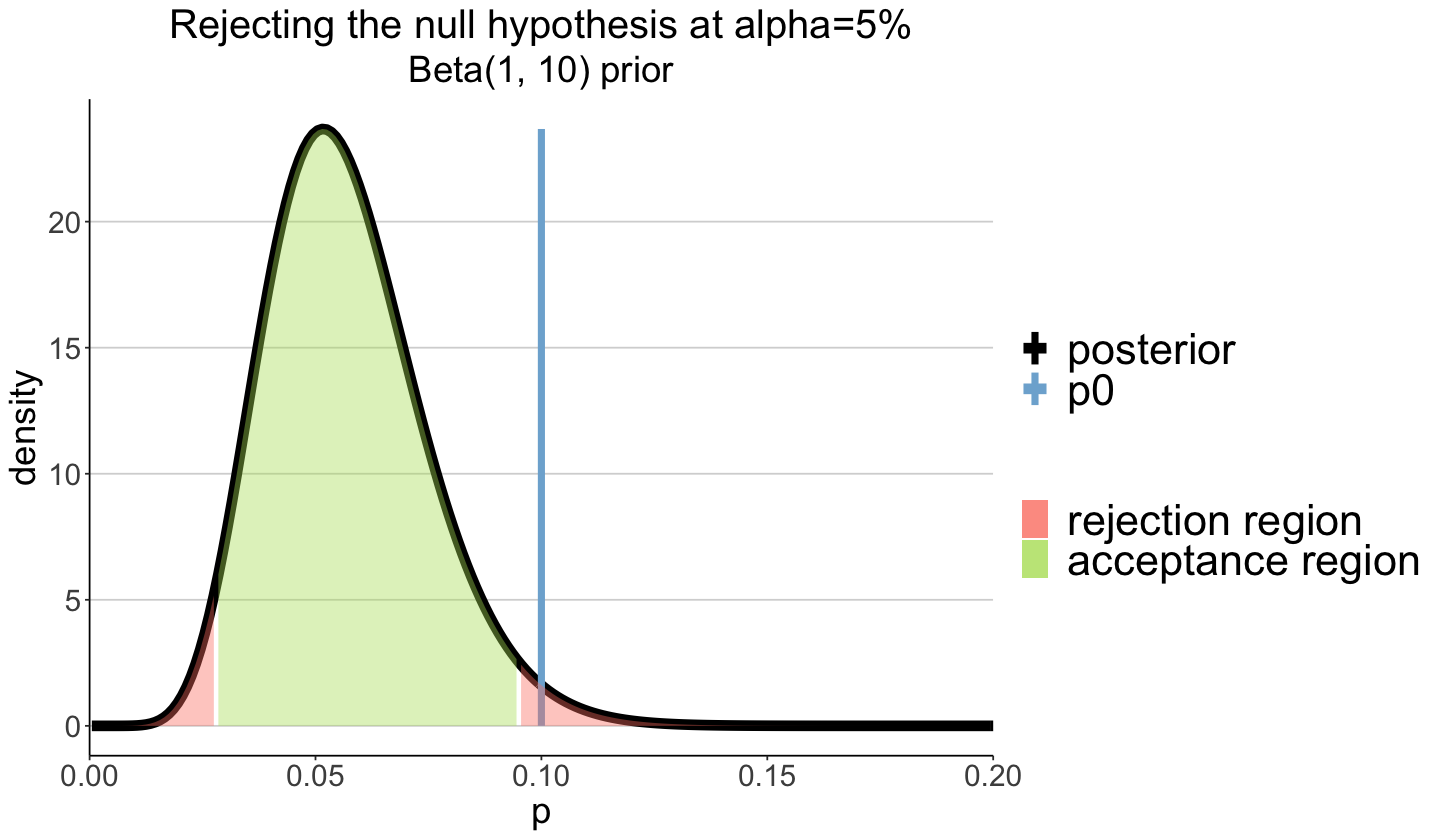

In [29]:
p0   <- 0.10

plt <- ggplot() +
geom_line(
    aes(
        x     = p,
        y     = posterior_1,
        color = "posterior"
    ),
    size      = 3,
    linetype  = "solid"
) +
geom_linerange(
    aes(
        x     = p0,
        ymin  = 0,
        ymax  = max(posterior_1),
        color = "p0"
    ),
    linetype  = "solid",
    size      = 2
) +
geom_area(
    aes(
        x     = p[(p < min_ci_1)],
        y     = posterior_1[(p < min_ci_1)],
        fill  = "rejection region"
    ),
    alpha     = 0.4
) +
geom_area(
    aes(
        x     = p[(p > max_ci_1)],
        y     = posterior_1[(p > max_ci_1)],
        fill  = "rejection region"
    ),
    alpha     = 0.4
) +
geom_area(
    aes(
        x     = p[(p > min_ci_1) & (p < max_ci_1)],
        y     = posterior_1[(p > min_ci_1) & (p < max_ci_1)],
        fill  = "acceptance region"
    ),
    alpha     = 0.4
) +
theme_classic() +
theme(
    plot.title    = element_text(size = fontsize + 2, hjust = 0.5),
    plot.subtitle = element_text(size = fontsize, hjust = 0.5),
    axis.title    = element_text(size = fontsize),
    axis.text     = element_text(size = fontsize - 4),
    legend.title  = element_text(size = fontsize),
    legend.text   = element_text(size = fontsize + 4),
    # legend.position = c(0.8, 0.825),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title    = glue("Rejecting the null hypothesis at alpha=5%"),
    x        = "p",
    y        = "density",
    subtitle = "Beta(1, 10) prior"
) +
coord_cartesian(xlim = c(0, 0.2)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_color_manual(
     name = "",
     values = c("black", colors[2]),
     breaks = c("posterior", "p0")
) +
scale_fill_manual(
     name = "",
     values = c(colors[1], colors[3]),
     breaks = c("rejection region", "acceptance region")
)

plt

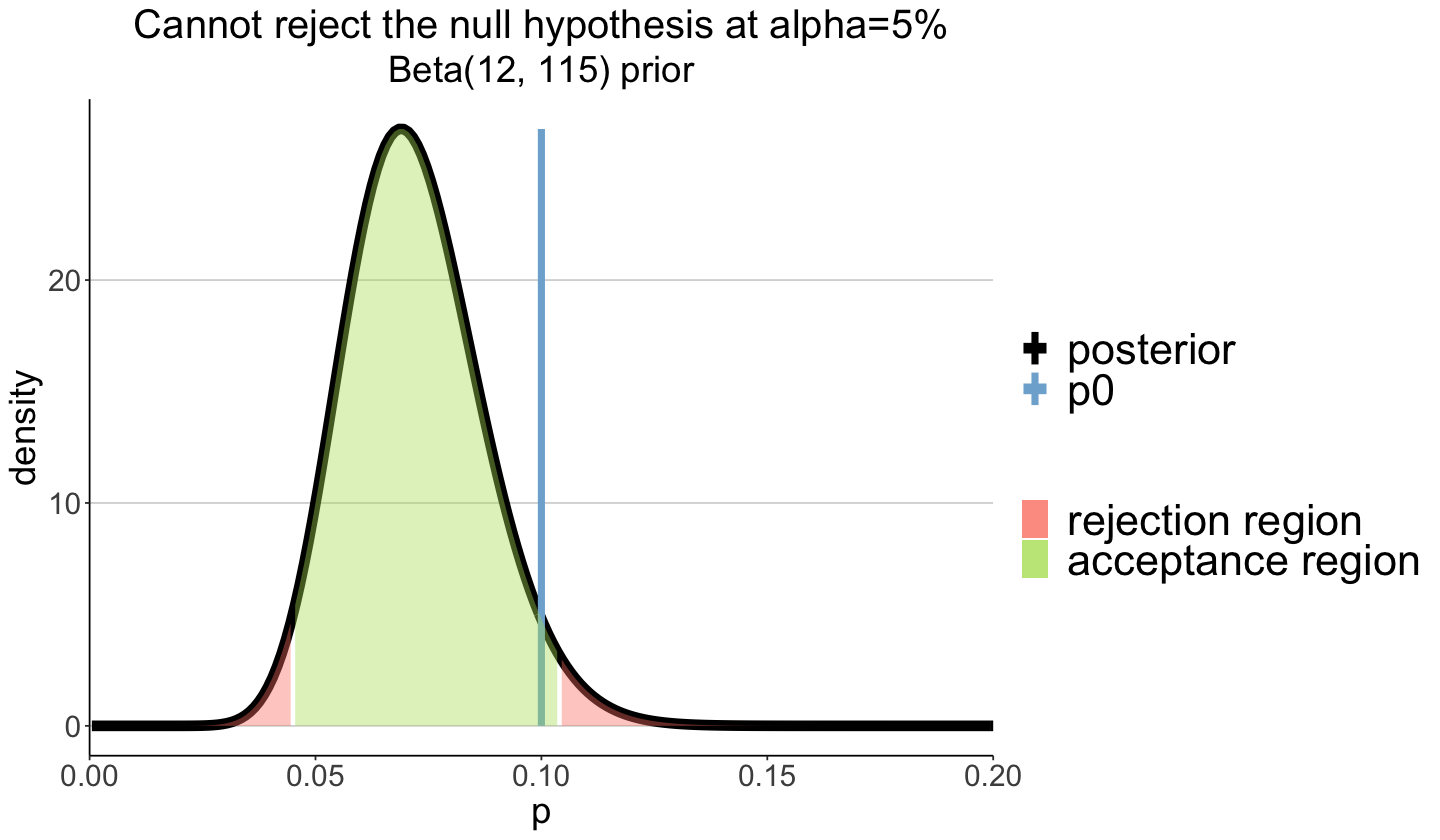

In [224]:
p0   <- 0.10

plt <- ggplot() +
geom_line(
    aes(
        x     = p,
        y     = posterior_2,
        color = "posterior"
    ),
    size      = 3,
    linetype  = "solid"
) +
geom_linerange(
    aes(
        x     = p0,
        ymin  = 0,
        ymax  = max(posterior_2),
        color = "p0"
    ),
    linetype  = "solid",
    size      = 2
) +
geom_area(
    aes(
        x     = p[(p < min_ci_2)],
        y     = posterior_2[(p < min_ci_2)],
        fill  = "rejection region"
    ),
    alpha     = 0.4
) +
geom_area(
    aes(
        x     = p[(p > max_ci_2)],
        y     = posterior_2[(p > max_ci_2)],
        fill  = "rejection region"
    ),
    alpha     = 0.4
) +
geom_area(
    aes(
        x     = p[(p > min_ci_2) & (p < max_ci_2)],
        y     = posterior_2[(p > min_ci_2) & (p < max_ci_2)],
        fill  = "acceptance region"
    ),
    alpha     = 0.4
) +
theme_classic() +
theme(
    plot.title    = element_text(size = fontsize + 2, hjust = 0.5),
    plot.subtitle = element_text(size = fontsize, hjust = 0.5),
    axis.title    = element_text(size = fontsize),
    axis.text     = element_text(size = fontsize - 4),
    legend.title  = element_text(size = fontsize),
    legend.text   = element_text(size = fontsize + 4),
    # legend.position = c(0.8, 0.825),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title    = glue("Cannot reject the null hypothesis at alpha=5%"),
    x        = "p",
    y        = "density",
    subtitle = "Beta(12, 115) prior"
) +
coord_cartesian(xlim = c(0, 0.2)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_color_manual(
     name = "",
     values = c("black", colors[2]),
     breaks = c("posterior", "p0")
) +
scale_fill_manual(
     name = "",
     values = c(colors[1], colors[3]),
     breaks = c("rejection region", "acceptance region")
)

plt

Now the frequentist approach.

In [30]:
p_h0_1 <- 1 - pbeta(p0, a_post_1, b_post_1)
p_h0_2 <- 1 - pbeta(p0, a_post_2, b_post_2)

cat(
    "Beta(1, 10) prior:", "\n",
    glue("pval = {round(p_h0_1, 4)}")
)
cat("\n")
cat(
    "Beta(12, 115) prior:", "\n",
    glue("pval = {round(p_h0_2, 4)}")
)

Beta(1, 10) prior: 
 pval = 0.0157
Beta(12, 115) prior: 
 pval = 0.0412

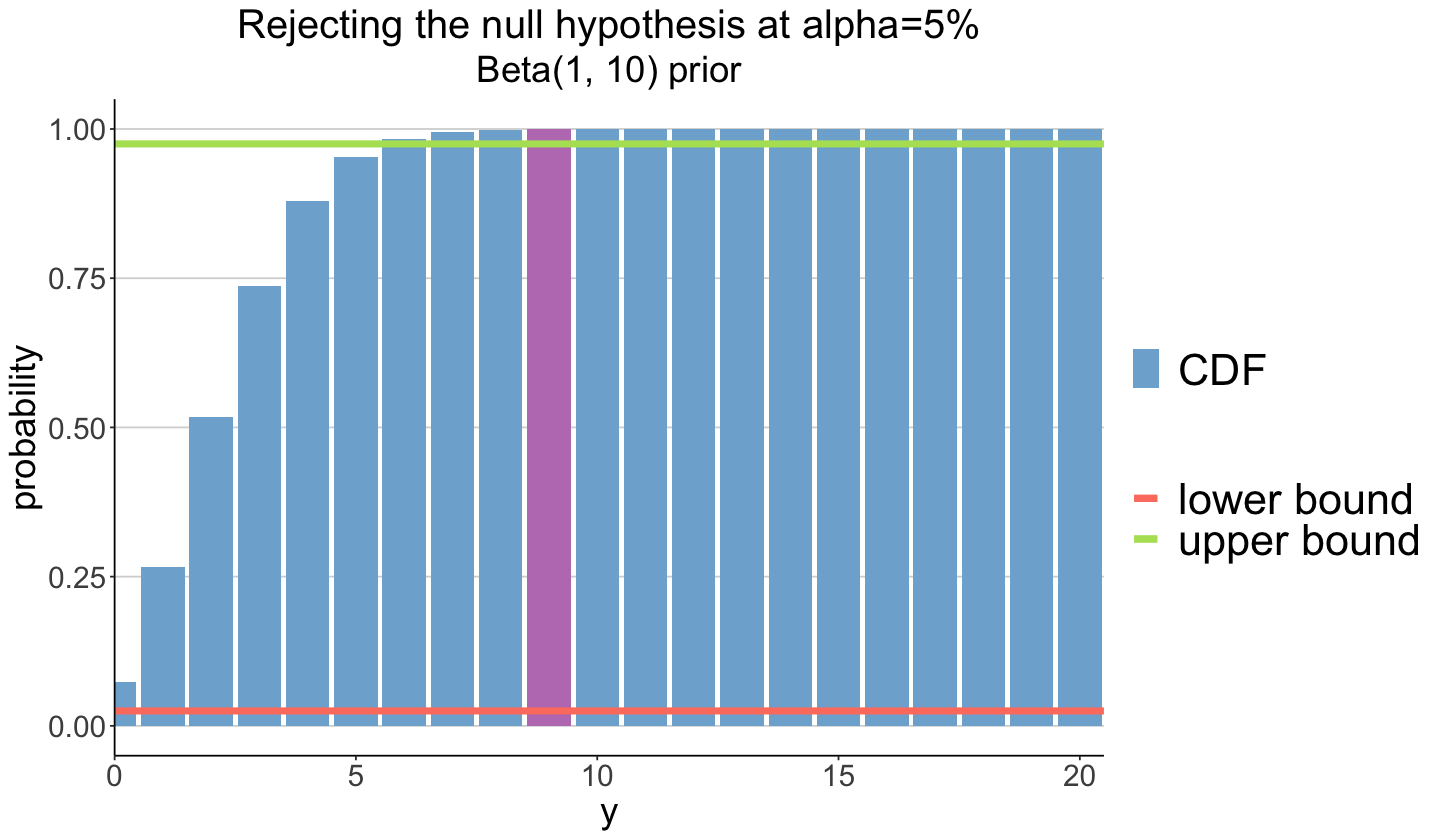

In [42]:
xgrid <- 0:30
cdf   <- pbinom(xgrid, size = n, prob = p_h0_1)

plt <- ggplot() +
geom_col(aes(x = xgrid, y = cdf, fill = "CDF")) +
geom_col(aes(x = 9,    y = pbinom(9, size = n, prob = p_h0_1)), fill = colors[4]) +
geom_hline(aes(yintercept = 0.025, color = "lower bound"), size = 2) +
geom_hline(aes(yintercept = 0.975, color = "upper bound"), size = 2) +
theme_classic() +
theme(
    plot.title   = element_text(size = fontsize + 2, hjust = 0.5),
    plot.subtitle = element_text(size = fontsize, hjust = 0.5),
    axis.title   = element_text(size = fontsize),
    axis.text    = element_text(size = fontsize - 4),
    legend.title = element_text(size = fontsize),
    legend.text  = element_text(size = fontsize + 4),
    # legend.position = c(0.8, 0.825),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title = glue("Rejecting the null hypothesis at alpha=5%"),
    x     = "y",
    y     = "probability",
    subtitle = "Beta(1, 10) prior"
) +
coord_cartesian(xlim = c(0, 20.5), ylim = c(0, 1)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_color_manual(
     name = "",
     values = c(colors[1], colors[3]),
     breaks = c("lower bound", "upper bound")
) +
scale_fill_manual(
     name = "",
     values = c(colors[2]),
     breaks = c("CDF")
)
plt

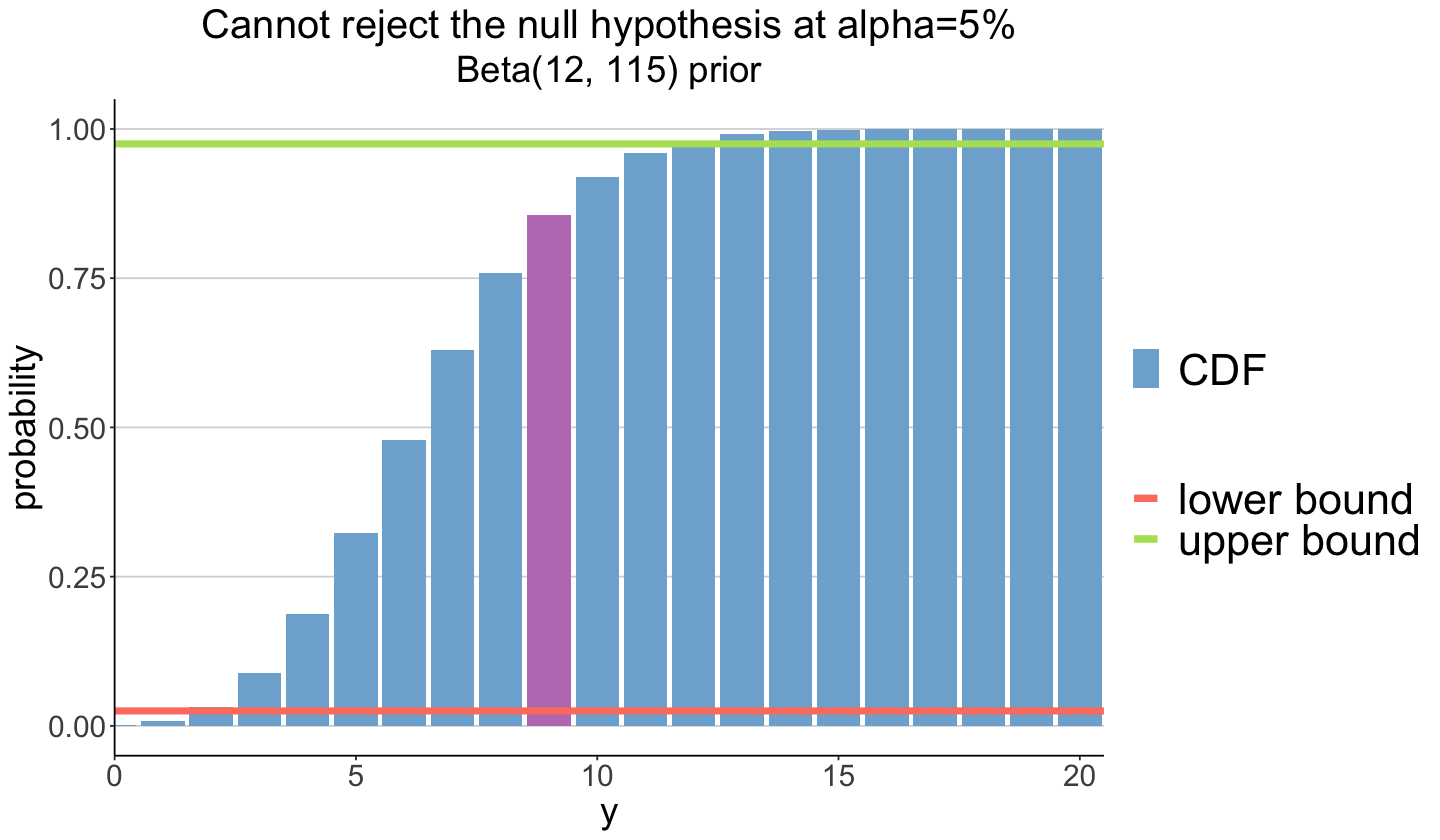

In [43]:
xgrid <- 0:30
cdf   <- pbinom(xgrid, size = n, prob = p_h0_2)

plt <- ggplot() +
geom_col(aes(x = xgrid, y = cdf, fill = "CDF")) +
geom_col(aes(x = 9,    y = pbinom(9, size = n, prob = p_h0_2)), fill = colors[4]) +
geom_hline(aes(yintercept = 0.025, color = "lower bound"), size = 2) +
geom_hline(aes(yintercept = 0.975, color = "upper bound"), size = 2) +
theme_classic() +
theme(
    plot.title   = element_text(size = fontsize + 2, hjust = 0.5),
    plot.subtitle = element_text(size = fontsize, hjust = 0.5),
    axis.title   = element_text(size = fontsize),
    axis.text    = element_text(size = fontsize - 4),
    legend.title = element_text(size = fontsize),
    legend.text  = element_text(size = fontsize + 4),
    # legend.position = c(0.8, 0.825),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title = glue("Cannot reject the null hypothesis at alpha=5%"),
    x     = "y",
    y     = "probability",
    subtitle = "Beta(12, 115) prior"
) +
coord_cartesian(xlim = c(0, 20.5), ylim = c(0, 1)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_color_manual(
     name = "",
     values = c(colors[1], colors[3]),
     breaks = c("lower bound", "upper bound")
) +
scale_fill_manual(
     name = "",
     values = c(colors[2]),
     breaks = c("CDF")
)
plt

We found that in the former case we still reject the null hypothesis and that in the latter we cannot reject the null hypothesis at a level of significance $\alpha=5\%$.

# Exercise 4

Solve point C) of Exercise 1 using a MCMC with JAGS.

In [70]:
# total number of tests
n <- 75
# number of successes
k <- 6
# we have k times 1 (success) and (n-k) times 0 (failure)
outcomes <- rep(c(1, 0), c(k, n - k))

data   <- NULL
data$x <- outcomes
data$n <- length(outcomes)

In [72]:
# JAGS
model <- "ex_4.bug"
jags_model <- jags.model(model, data)
# set burn in
update(jags_model, 1000)
chain <- coda.samples(jags_model, c("p"), n.iter = 10000)
summary <- (summary(chain))
print(summary)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 75
   Unobserved stochastic nodes: 2
   Total graph size: 80

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.0819167      0.0292122      0.0002921      0.0003006 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.03462 0.06042 0.07879 0.09993 0.14709 



In [91]:
# turning the mcmc.list into a tibble for ggplot plotting :D
s <- ggs(chain)
head(s)

Iteration,Chain,Parameter,value
<int>,<dbl>,<fct>,<dbl>
1,1,p,0.07761553
2,1,p,0.06687373
3,1,p,0.10088610
4,1,p,0.07790771
5,1,p,0.09157705
6,1,p,0.06166253


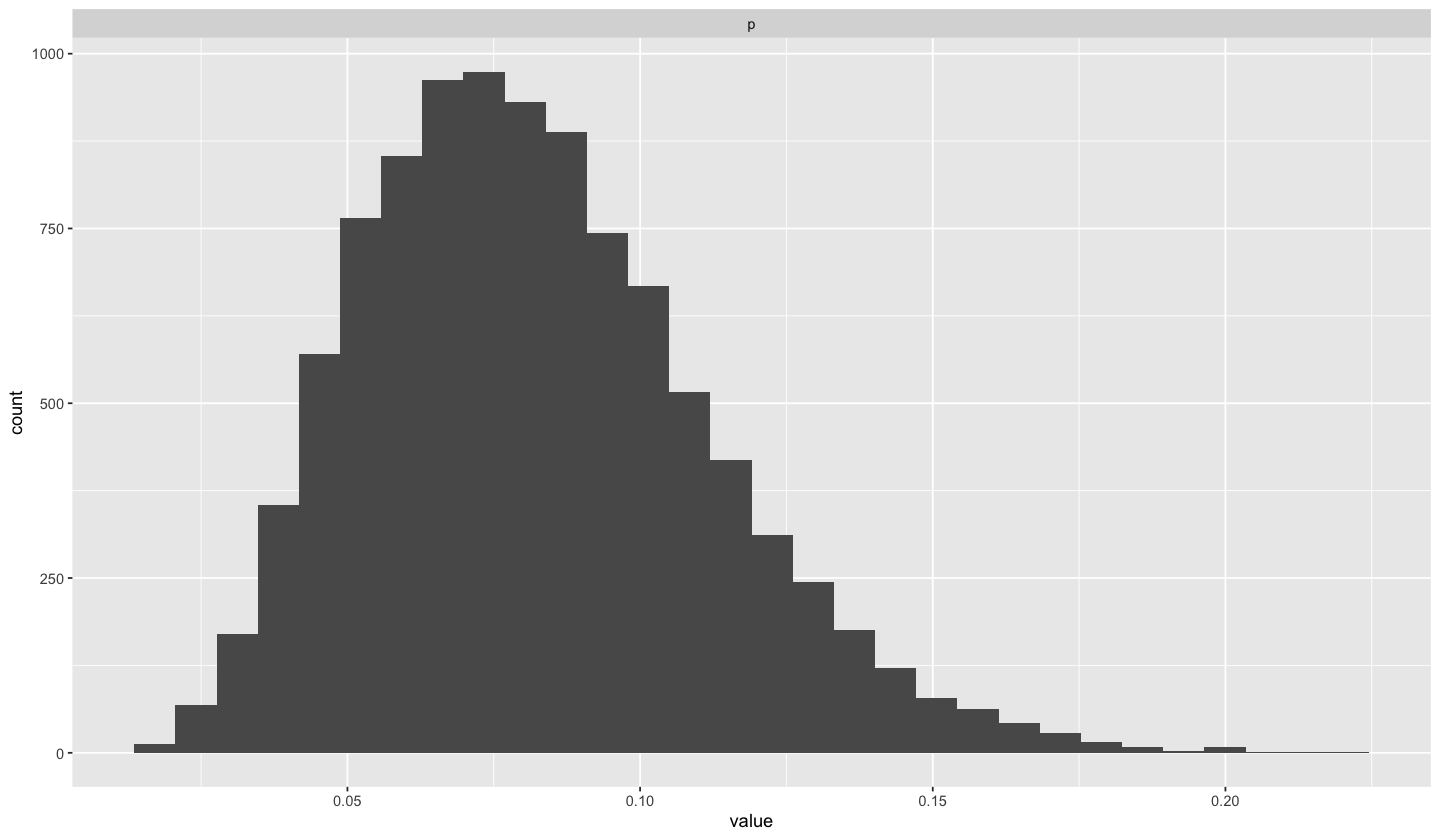

In [85]:
ggs_histogram(s)

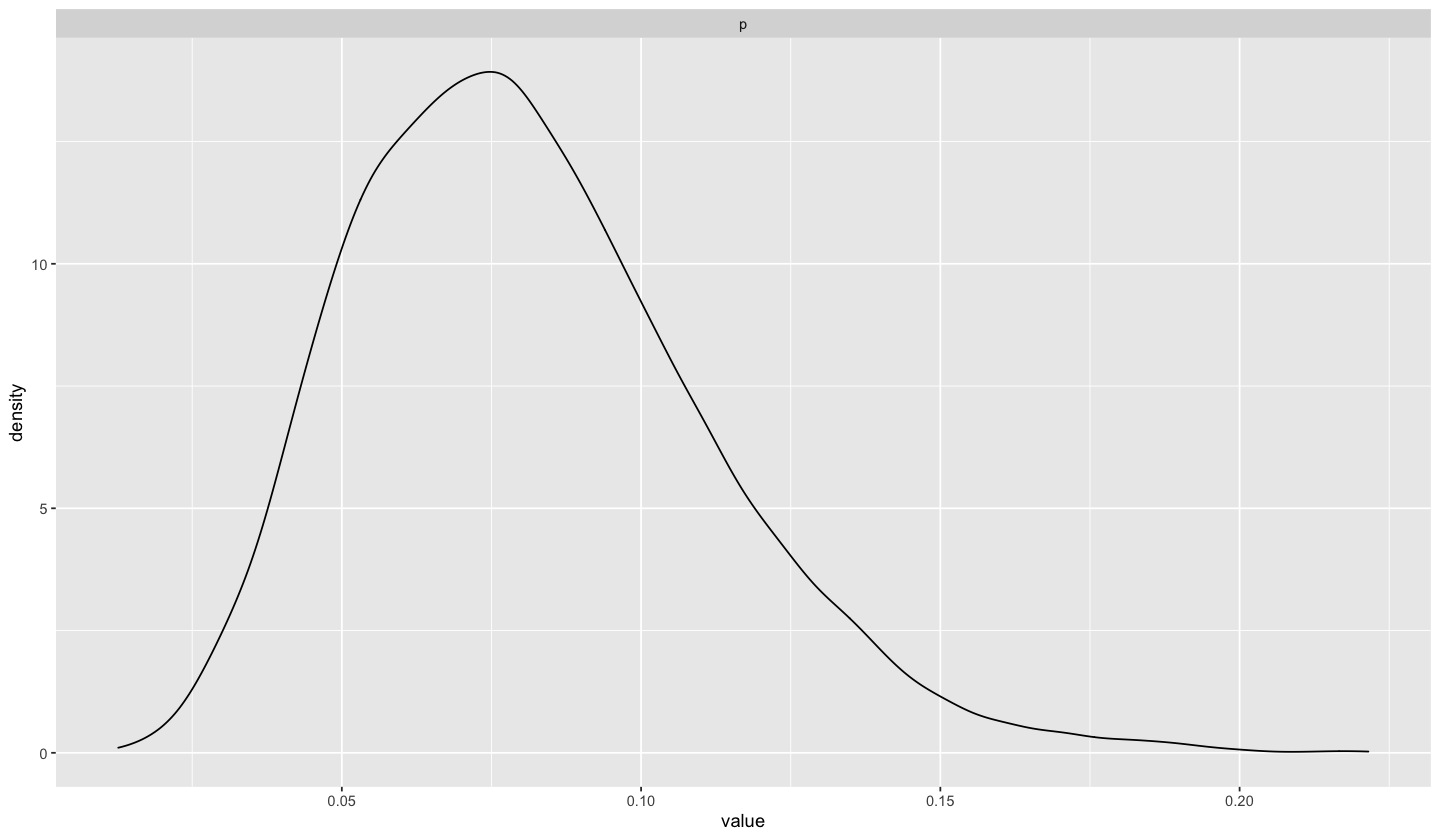

In [66]:
ggs_density(s)

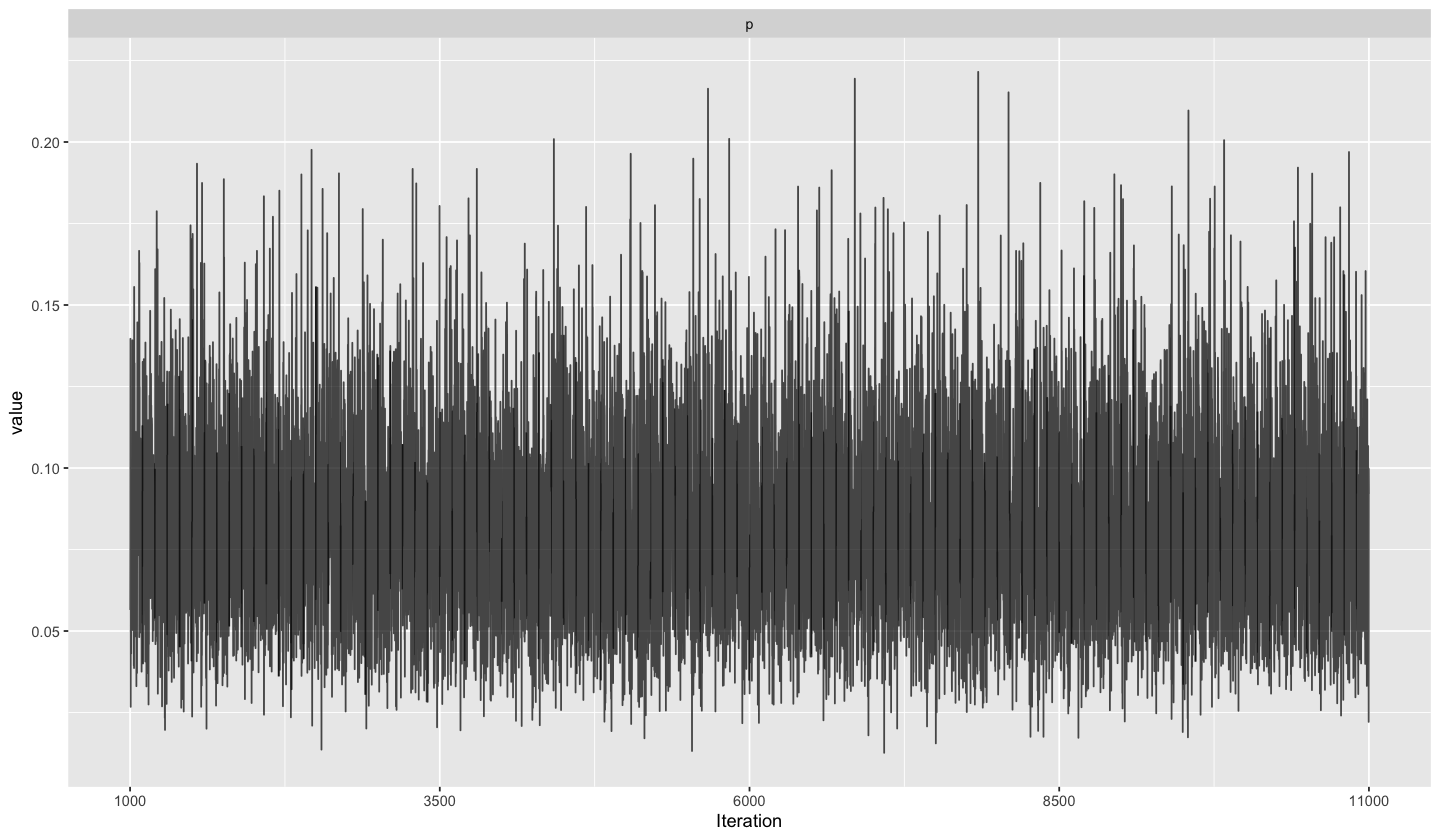

In [69]:
ggs_traceplot(s)

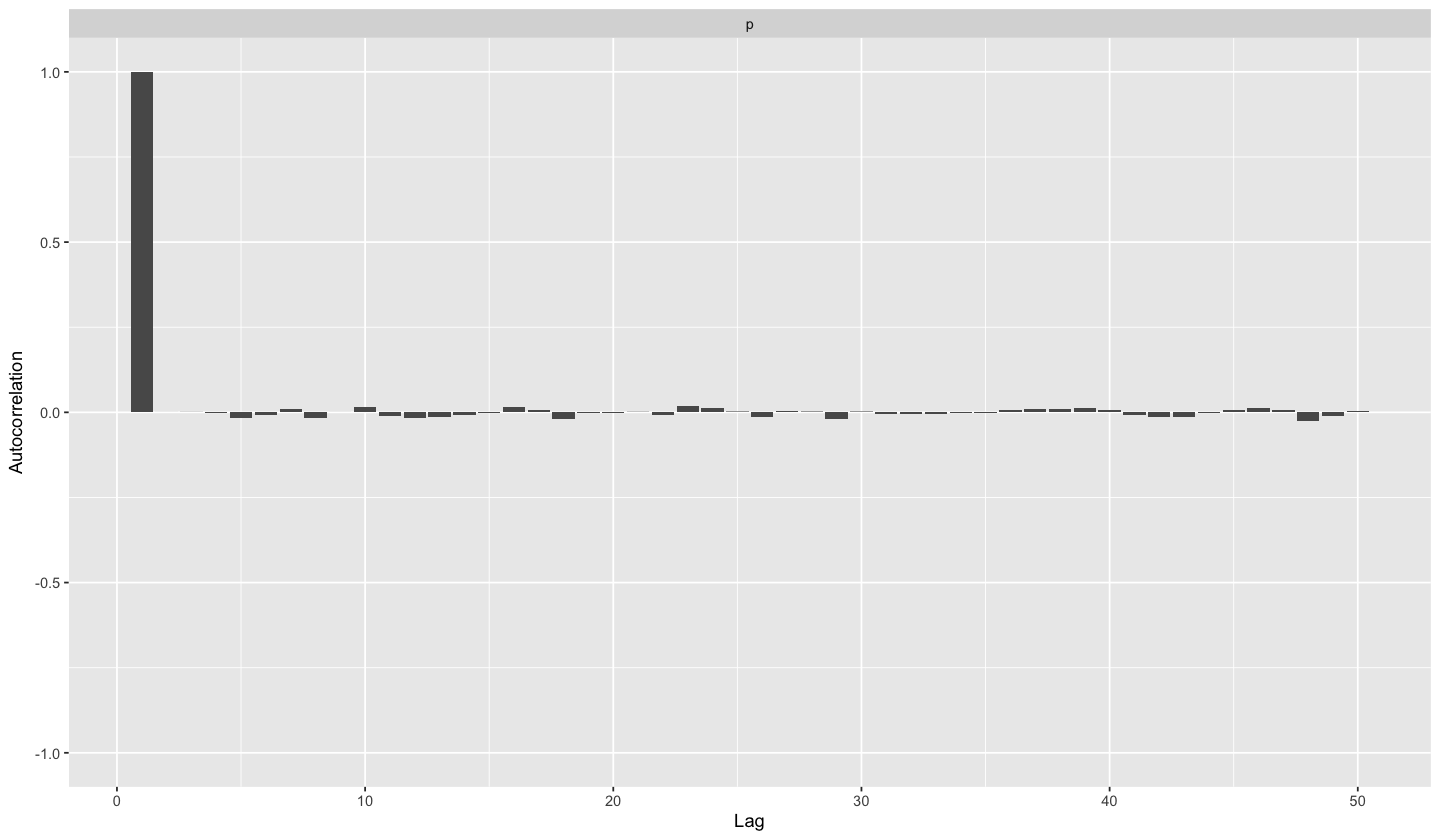

In [63]:
ggs_autocorrelation(s)

### Analytical vs MCMC comparison

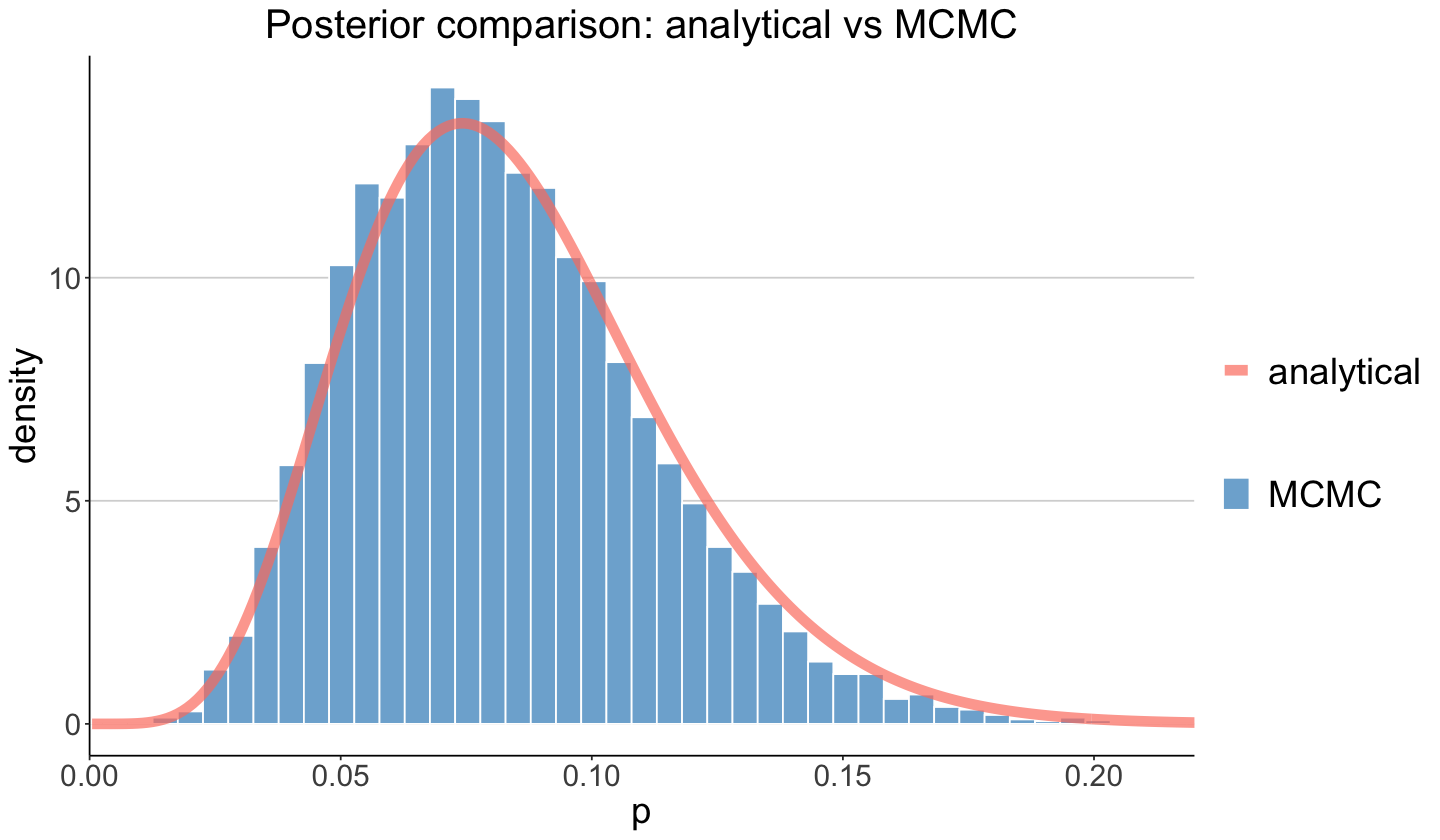

In [106]:
# compute alpha and beta for the prior beta distribution

mean_prior  <- 0.15
sigma_prior <- 0.14

a_prior <- ((1 - mean_prior) / sigma_prior^2 - 1 / mean_prior) * mean_prior^2
b_prior <- a_prior * (1 / mean_prior - 1)

# total number of tests
n <- 75
# number of successes
k <- 6

# posterior beta parameters
a_post <- a_prior + k
b_post <- b_prior + n - k

n_grid  <- 1000
# the parameter we want to infer
p       <- seq(from = 1 / (2 * n_grid), by = 1 / n_grid, length.out = n_grid)
delta_p <- 1 / n_grid

# posterior distribution
posterior  <- dbeta(x = p, shape1 = a_post,  shape2 = b_post)

# PLOT
plt <- ggplot() +
geom_histogram(
    aes(s$value, y=..density.., fill='MCMC'), 
    color='white', 
    bins=200
) +
geom_line(
    aes(x = p, y = posterior, color = "analytical"), 
    size = 3, 
    alpha = 0.7,
    linetype = "solid"
)  +
theme_classic() +
theme(
    plot.title   = element_text(size = fontsize + 2, hjust = 0.5),
    axis.title   = element_text(size = fontsize),
    axis.text    = element_text(size = fontsize - 4),
    legend.title = element_text(size = fontsize),
    legend.text  = element_text(size = fontsize),
    # legend.position = c(0.8, 0.825),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title = glue("Posterior comparison: analytical vs MCMC"),
    x     = "p",
    y     = "density",
) +
coord_cartesian(xlim = c(0, 0.22)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_color_manual(
     name = "",
     values = c(colors[1]),
     breaks = c("analytical")
) +
scale_fill_manual(
     name = "",
     values = c(colors[2]),
     breaks = c("MCMC")
)

plt

# Exercise 5

Analyze the data of Exercise 2 using a MCMC with JAGS.

### Using a FLAT prior

In [126]:
y   <- c(  0,  1,  2,  3, 4)
n_1 <- c(109, 65, 22,  3, 1)
n_2 <- c(144, 91, 32, 11, 2)

outcomes_1 <- rep(y, n_1)
outcomes_2 <- rep(y, n_2)

data   <- NULL
data$x <- outcomes_1
data$y <- outcomes_2

# JAGS
model <- "ex_5_1.bug"
jags_model <- jags.model(model, data)
# burn in
update(jags_model, 1000)
chain <- coda.samples(jags_model, c("lambda_1", "lambda_2"), n.iter = 10000)
summary <- (summary(chain))
print(summary)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 480
   Unobserved stochastic nodes: 2
   Total graph size: 483

Initializing model


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean      SD  Naive SE Time-series SE
lambda_1 0.6154 0.05616 0.0005616      0.0007358
lambda_2 0.7039 0.04978 0.0004978      0.0006654

2. Quantiles for each variable:

           2.5%    25%    50%    75%  97.5%
lambda_1 0.5093 0.5768 0.6146 0.6523 0.7299
lambda_2 0.6080 0.6703 0.7030 0.7361 0.8055



In [127]:
# turning the mcmc.list into a tibble for ggplot plotting :D
s <- ggs(chain)
head(s)

Iteration,Chain,Parameter,value
<int>,<dbl>,<fct>,<dbl>
1,1,lambda_1,0.6753540
2,1,lambda_1,0.5355214
3,1,lambda_1,0.5119962
4,1,lambda_1,0.5770797
5,1,lambda_1,0.5371133
6,1,lambda_1,0.5793646


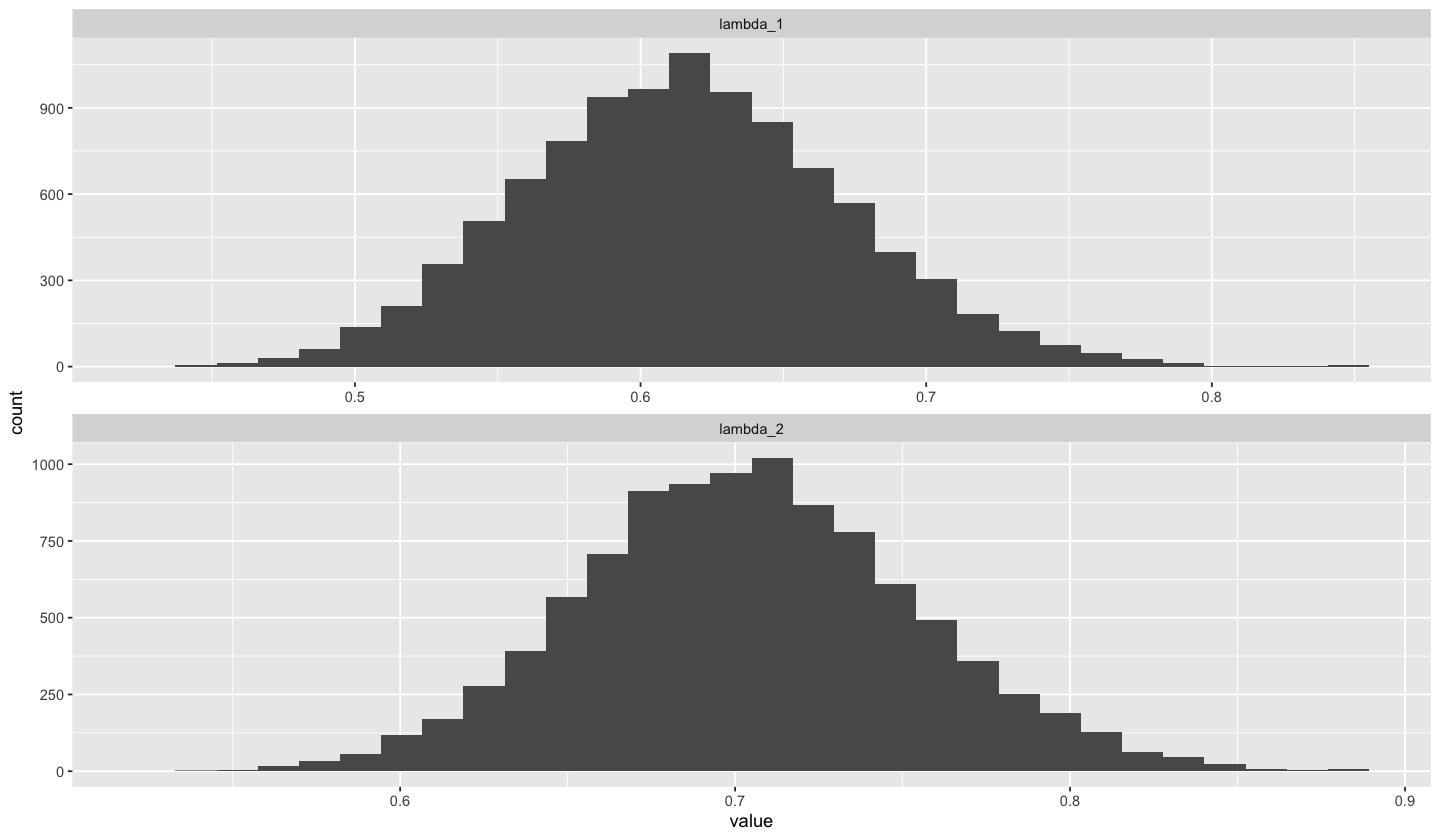

In [132]:
ggs_histogram(s)

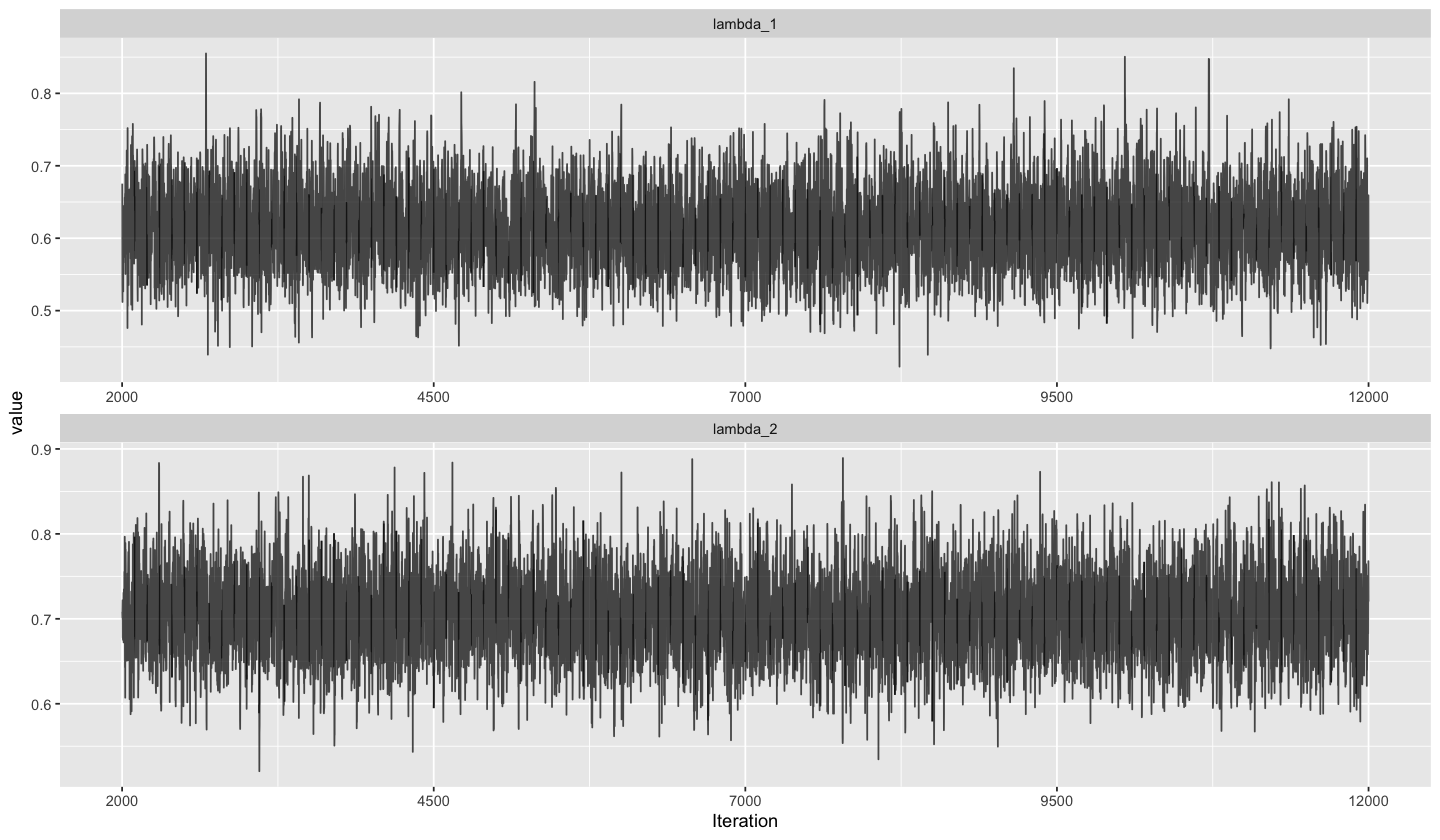

In [129]:
ggs_traceplot(s)

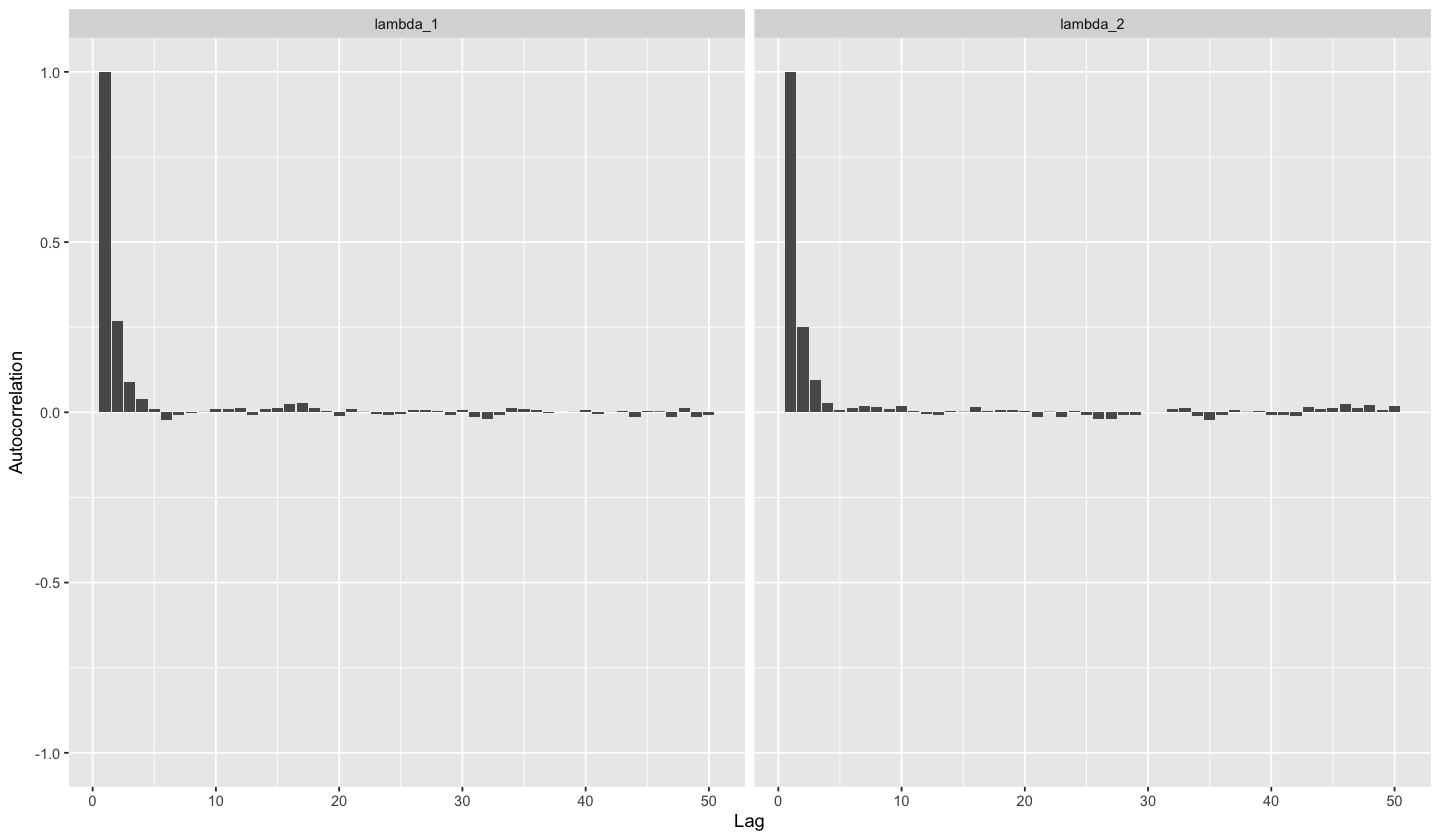

In [130]:
ggs_autocorrelation(s)

### Using Jeffrey's prior

In [133]:
y   <- c(  0,  1,  2,  3, 4)
n_1 <- c(109, 65, 22,  3, 1)
n_2 <- c(144, 91, 32, 11, 2)

outcomes_1 <- rep(y, n_1)
outcomes_2 <- rep(y, n_2)

data   <- NULL
data$x <- outcomes_1
data$y <- outcomes_2

# JAGS
model <- "ex_5_2.bug"
jags_model <- jags.model(model, data)
# burn in
update(jags_model, 1000)
chain <- coda.samples(jags_model, c("lambda_1", "lambda_2"), n.iter = 10000)
summary <- (summary(chain))
print(summary)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 480
   Unobserved stochastic nodes: 2
   Total graph size: 485

Initializing model


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean      SD  Naive SE Time-series SE
lambda_1 0.6167 0.05627 0.0005627      0.0007135
lambda_2 0.7055 0.05038 0.0005038      0.0006242

2. Quantiles for each variable:

           2.5%    25%    50%    75%  97.5%
lambda_1 0.5104 0.5782 0.6150 0.6535 0.7309
lambda_2 0.6107 0.6708 0.7036 0.7390 0.8081



In [134]:
# turning the mcmc.list into a tibble for ggplot plotting :D
s <- ggs(chain)
head(s)

Iteration,Chain,Parameter,value
<int>,<dbl>,<fct>,<dbl>
1,1,lambda_1,0.6052824
2,1,lambda_1,0.5868828
3,1,lambda_1,0.5496475
4,1,lambda_1,0.4990638
5,1,lambda_1,0.6389996
6,1,lambda_1,0.6057406


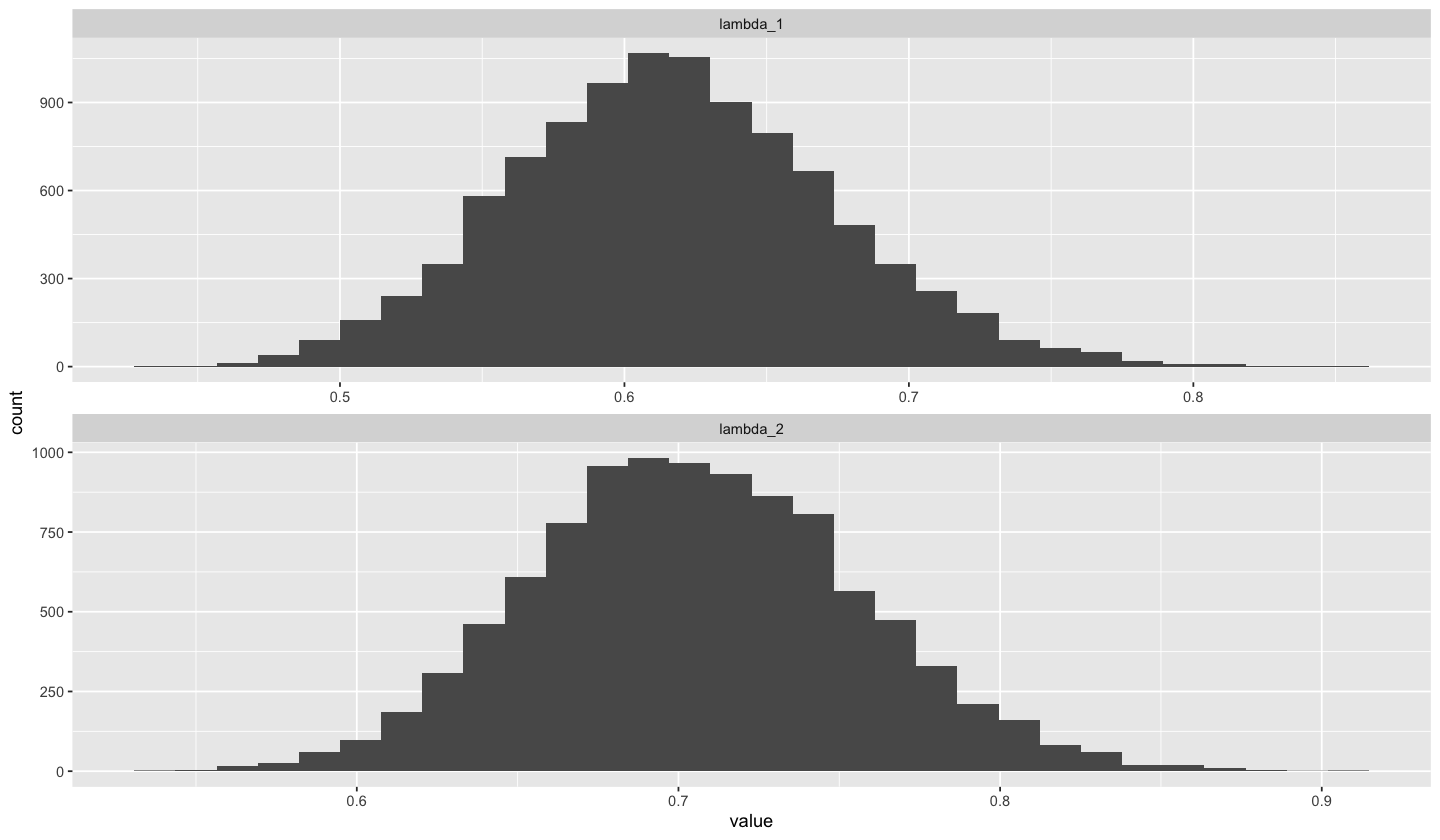

In [135]:
ggs_histogram(s)

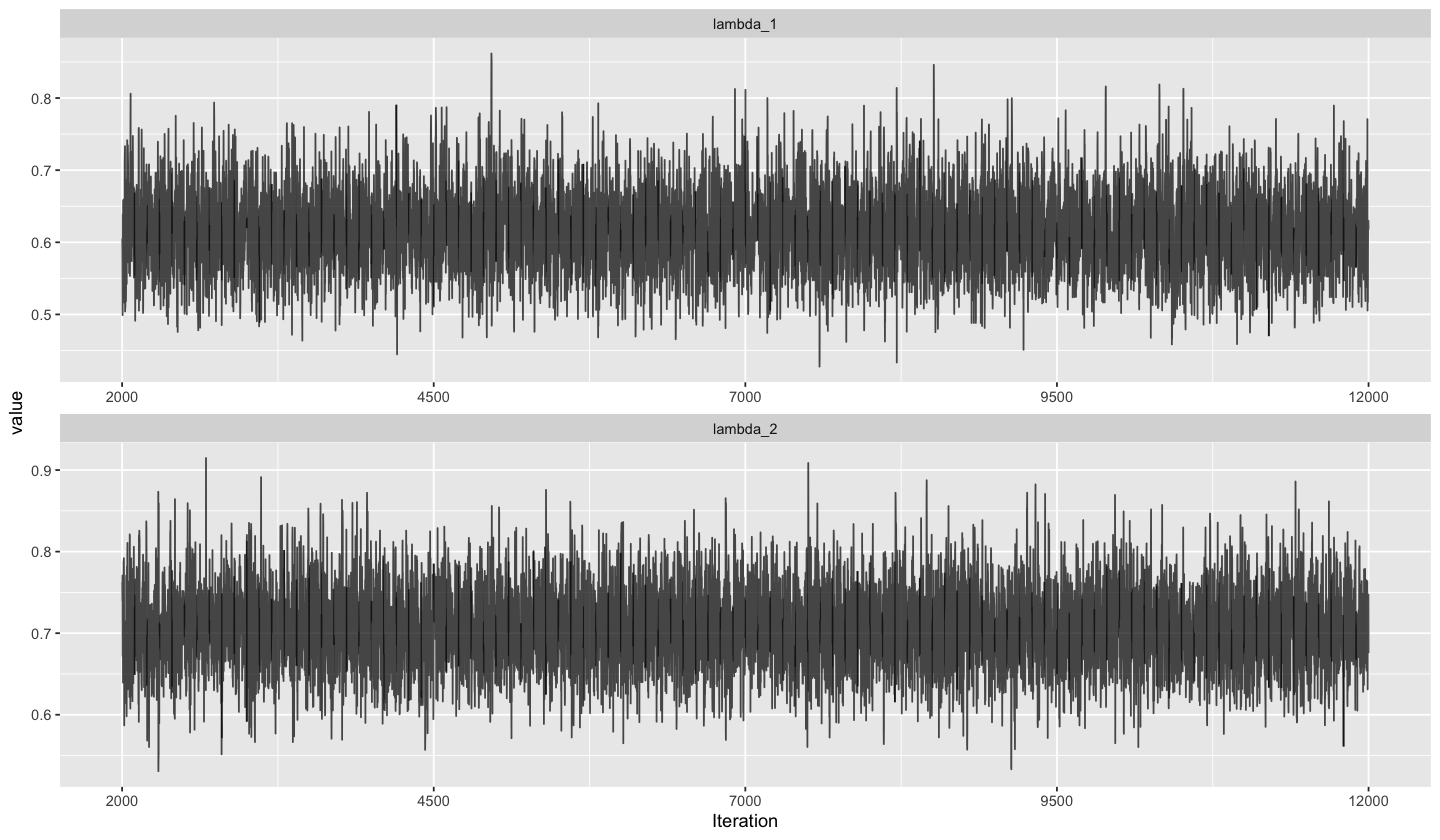

In [136]:
ggs_traceplot(s)

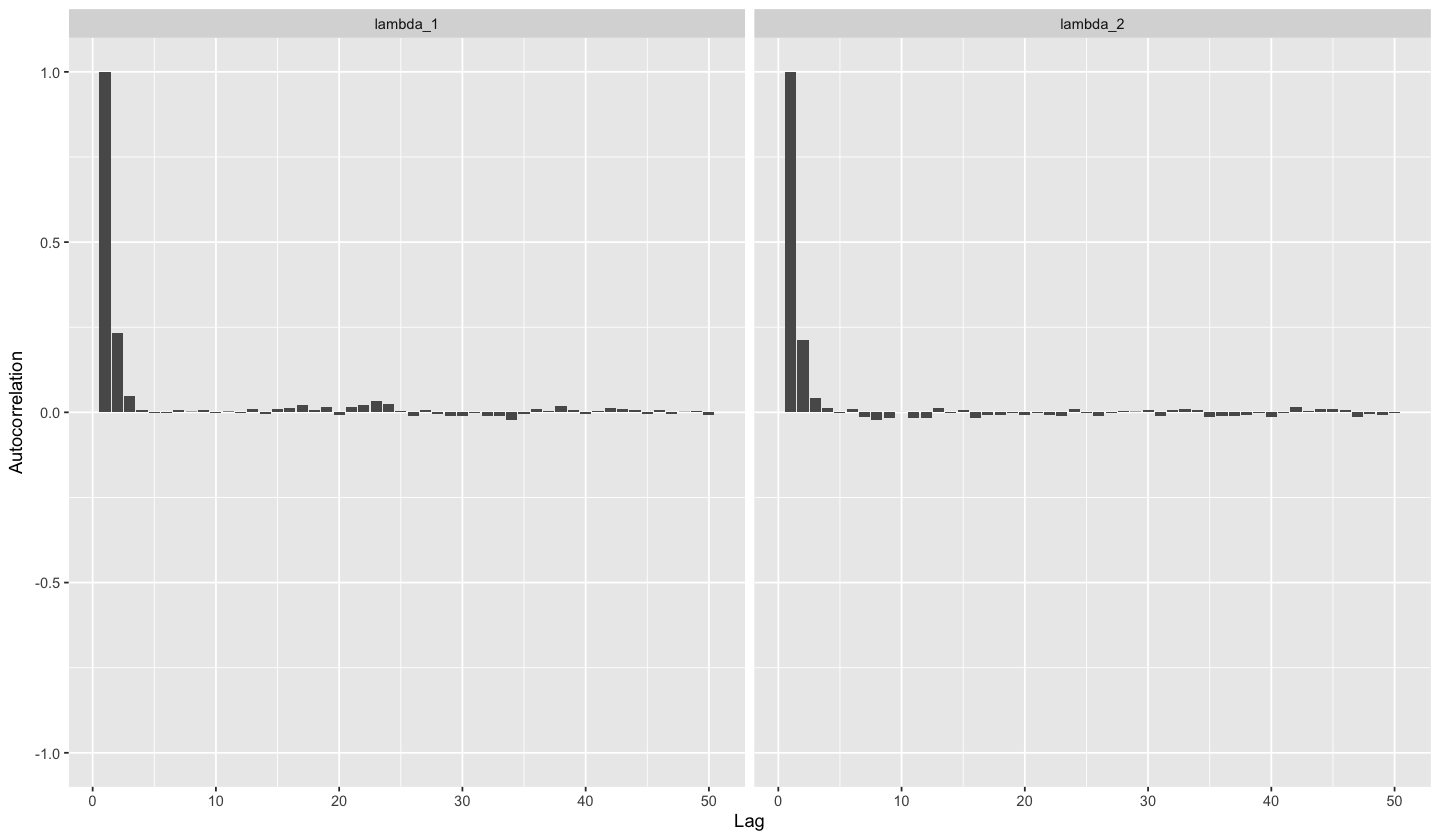

In [137]:
ggs_autocorrelation(s)

# Exercise 6

Solve point B) and C) of Exercise 3 using a MCMC with JAGS.

In [138]:
# total number of tests
n <- 116
# number of successes
k <- 11

# priot beta parameters
a_prior <- 1
b_prior <- 10

# posterior beta parameters
a_post <- a_prior + k
b_post <- b_prior + n - k

n_grid  <- 1000
# the parameter we want to infer
p       <- seq(from = 1 / (2 * n_grid), by = 1 / n_grid, length.out = n_grid)
delta_p <- 1 / n_grid

# posterior distribution
posterior  <- dbeta(x = p, shape1 = a_post,  shape2 = b_post)

In [139]:
outcomes <- rep(c(1, 0), c(k, n - k))

data   <- NULL
data$x <- outcomes
data$n <- length(outcomes)

# JAGS
model <- "ex_6.bug"
jags_model <- jags.model(model, data)
# set burn in
update(jags_model, 1000)
chain <- coda.samples(jags_model, c("p"), n.iter = 10000)
summary <- (summary(chain))
print(summary)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 116
   Unobserved stochastic nodes: 2
   Total graph size: 121

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.0943590      0.0256636      0.0002566      0.0002566 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.05004 0.07600 0.09255 0.11016 0.15072 



In [140]:
# turning the mcmc.list into a tibble for ggplot plotting :D
s <- ggs(chain)
head(s)

Iteration,Chain,Parameter,value
<int>,<dbl>,<fct>,<dbl>
1,1,p,0.12384501
2,1,p,0.10327638
3,1,p,0.07166428
4,1,p,0.11429233
5,1,p,0.07461396
6,1,p,0.07753562


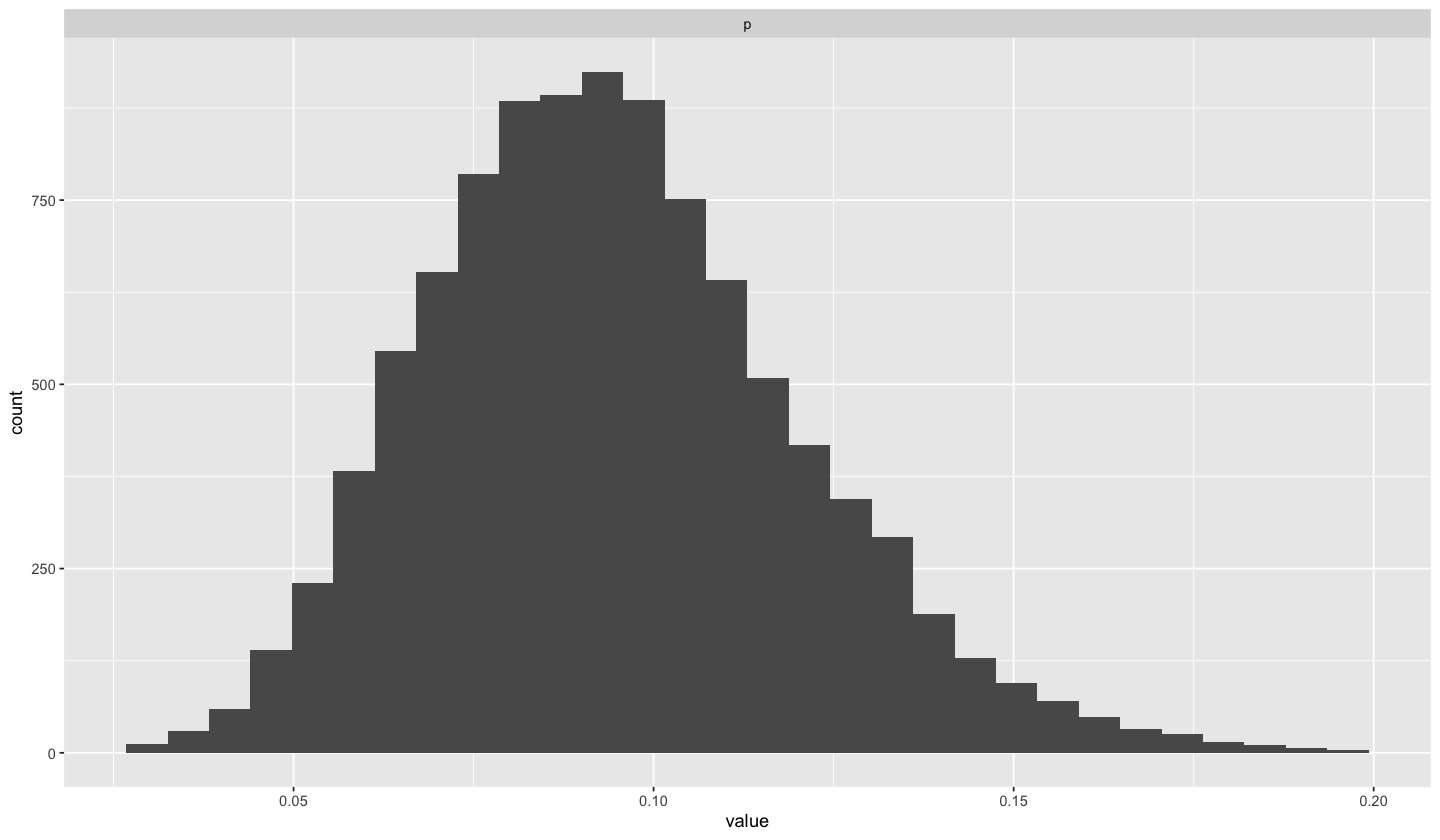

In [141]:
ggs_histogram(s)

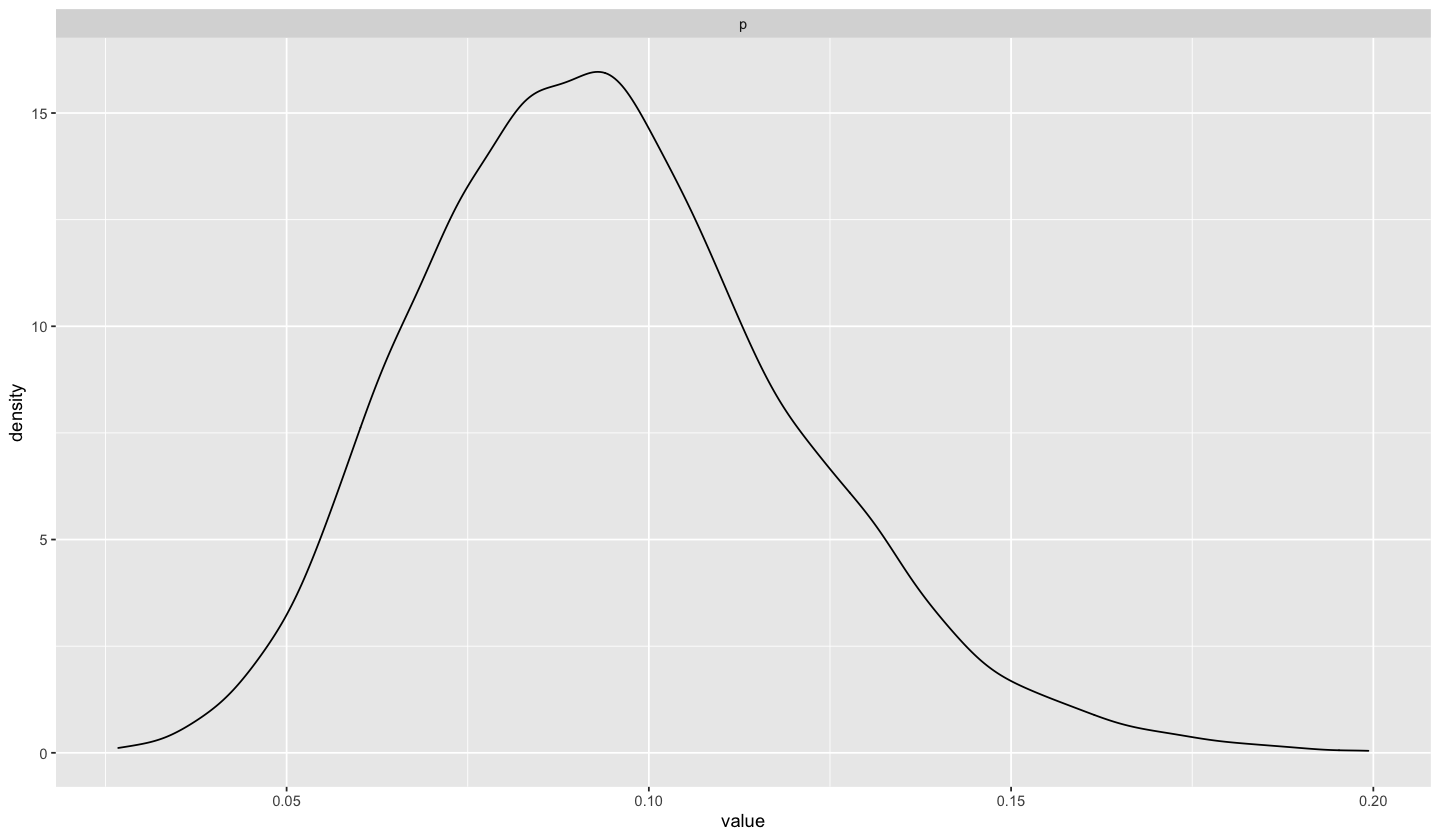

In [142]:
ggs_density(s)

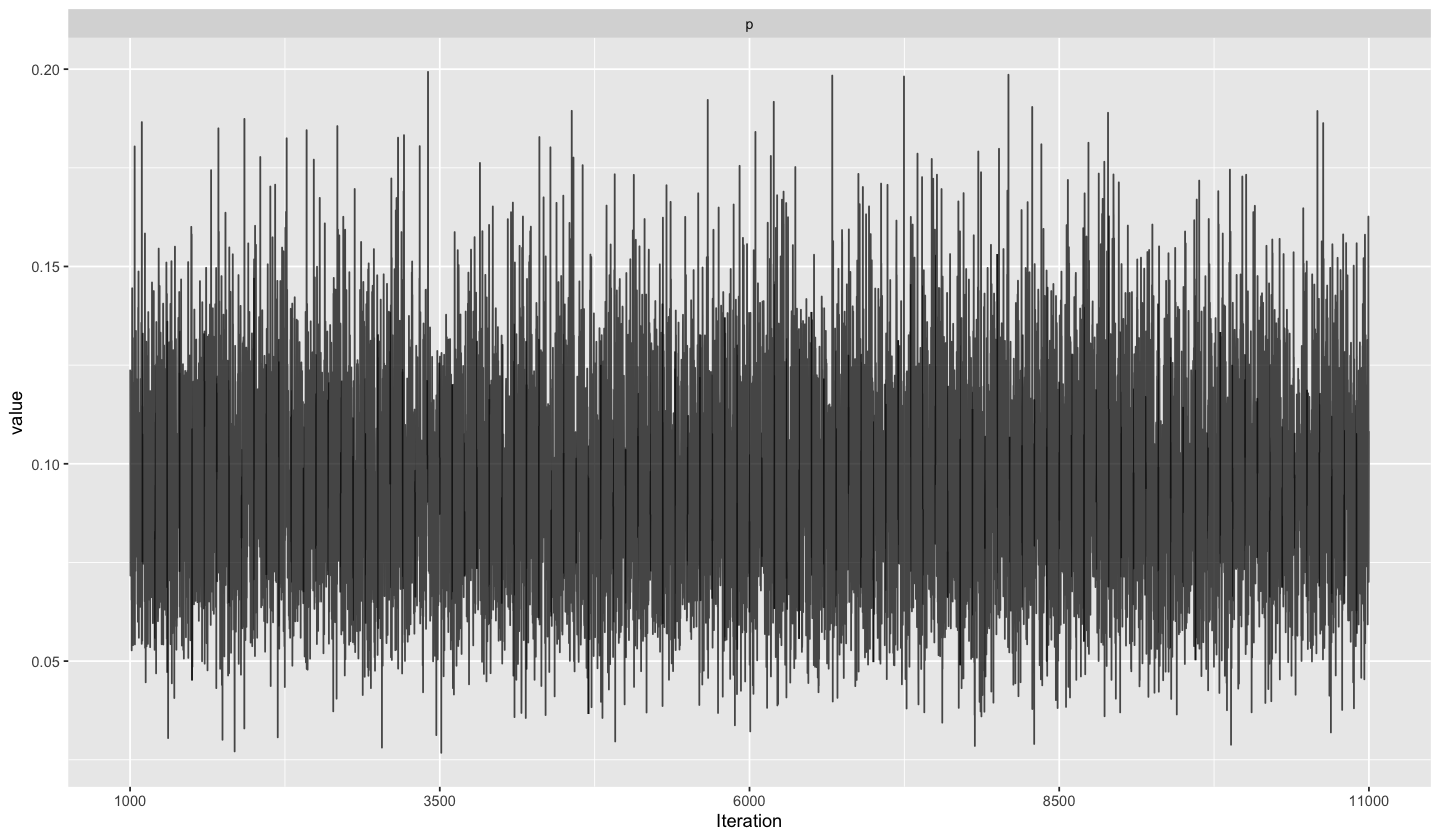

In [143]:
ggs_traceplot(s)

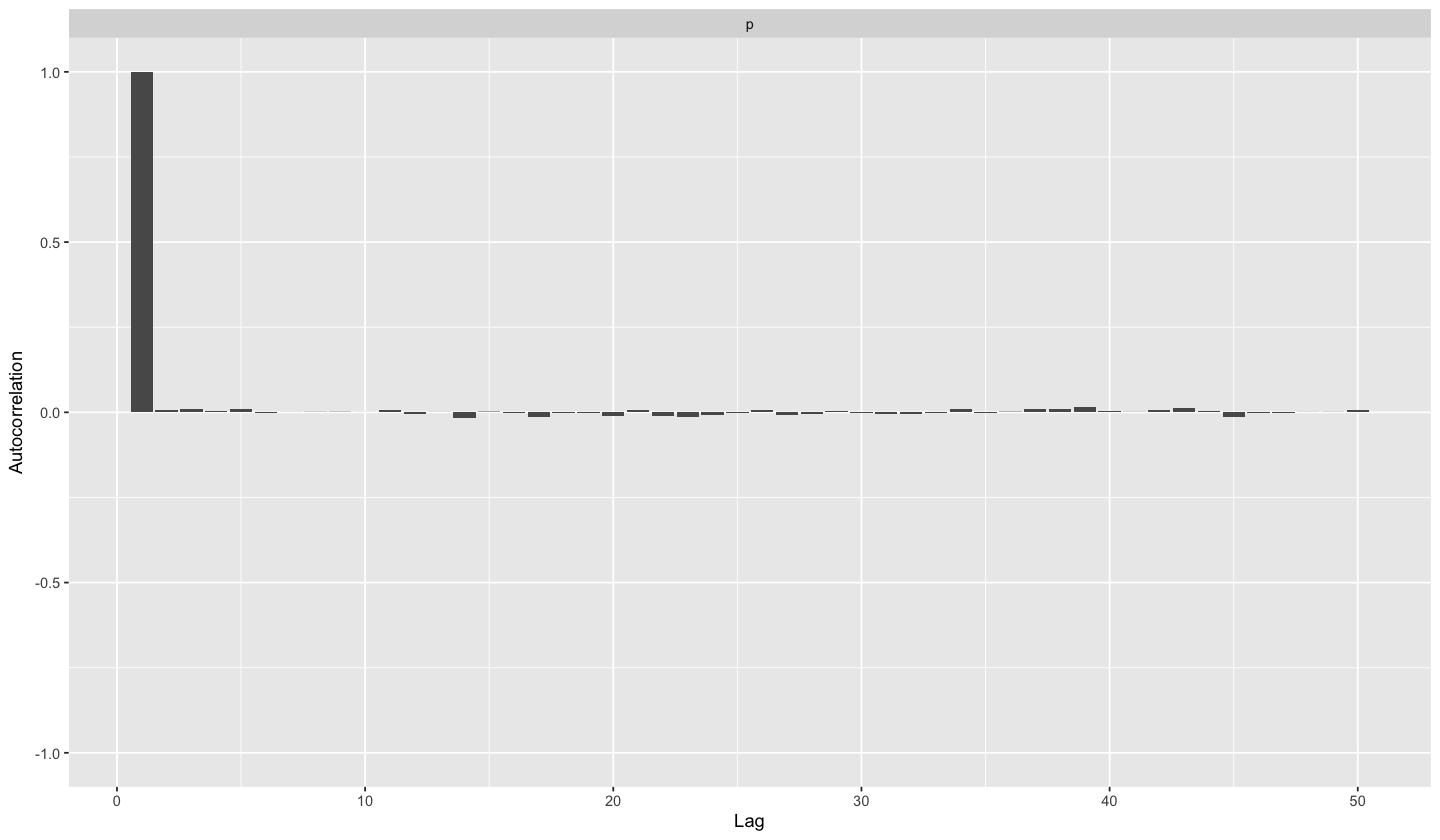

In [144]:
ggs_autocorrelation(s)

### Analytical vs MCMC comparison

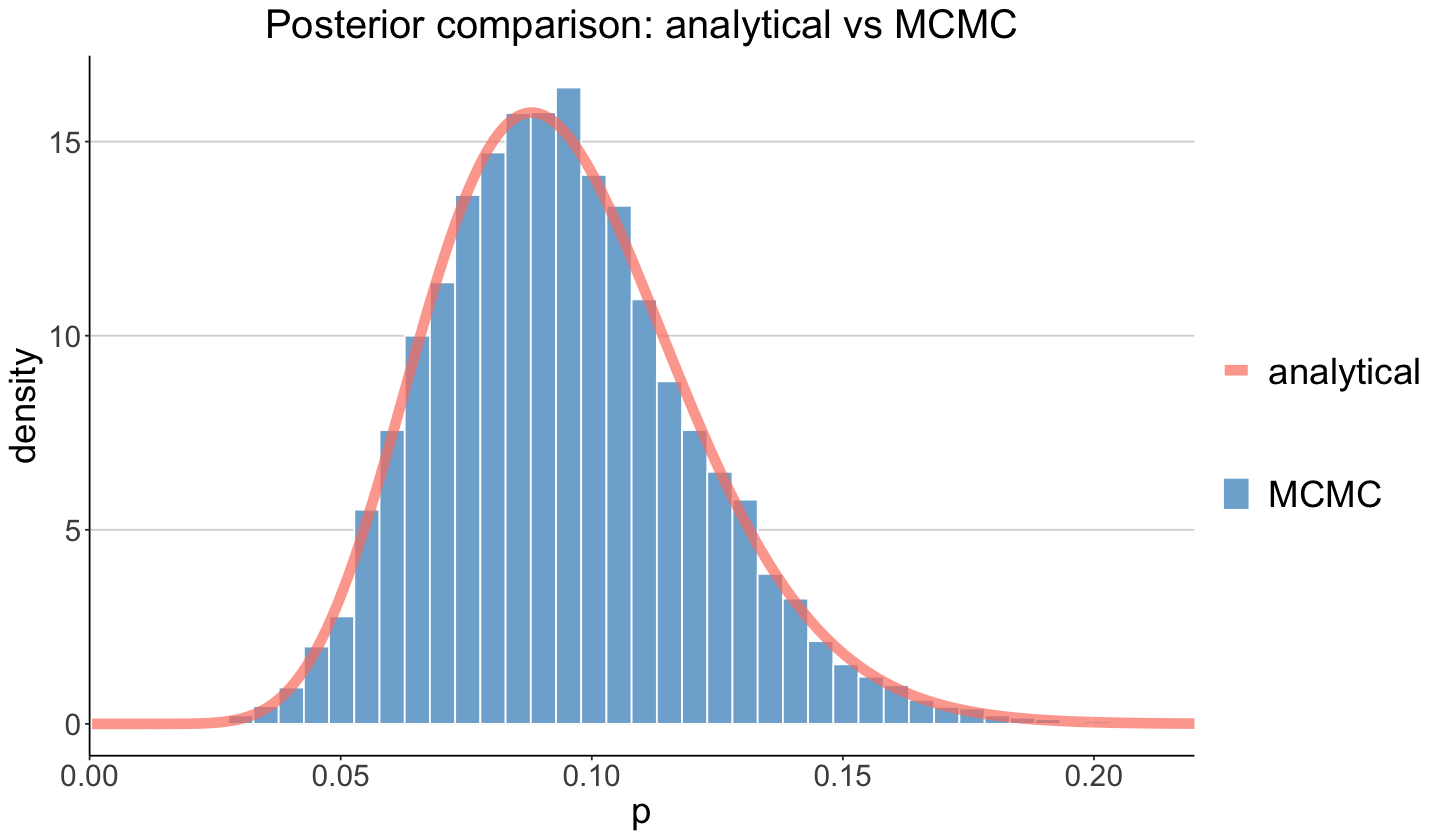

In [145]:
# PLOT
plt <- ggplot() +
geom_histogram(
    aes(s$value, y=..density.., fill='MCMC'), 
    color='white', 
    bins=200
) +
geom_line(
    aes(x = p, y = posterior, color = "analytical"), 
    size = 3, 
    alpha = 0.7,
    linetype = "solid"
)  +
theme_classic() +
theme(
    plot.title   = element_text(size = fontsize + 2, hjust = 0.5),
    axis.title   = element_text(size = fontsize),
    axis.text    = element_text(size = fontsize - 4),
    legend.title = element_text(size = fontsize),
    legend.text  = element_text(size = fontsize),
    # legend.position = c(0.8, 0.825),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title = glue("Posterior comparison: analytical vs MCMC"),
    x     = "p",
    y     = "density",
) +
coord_cartesian(xlim = c(0, 0.22)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_color_manual(
     name = "",
     values = c(colors[1]),
     breaks = c("analytical")
) +
scale_fill_manual(
     name = "",
     values = c(colors[2]),
     breaks = c("MCMC")
)

plt